# BRSR Data Analysis 📊


This Kaggle notebook explores the **Business Responsibility and Sustainability Report (BRSR)** filings made by Indian listed entities.

The dataset (`combined_brsr_data.csv`) contains XBRL‑extracted facts for each company‑year combination.

We'll walk through a concise exploratory data analysis (EDA) to understand coverage, identify key metrics, and surface preliminary insights.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install plotly seaborn wordcloud matplotlib

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv("combined_brsr_data.csv")

print(f"Loaded {df.shape[0]:,} rows and {df.shape[1]} columns")


Loaded 210,444 rows and 8 columns


In [4]:
df = pd.read_csv("combined_brsr_data.csv")
df

Sr.No.                                       Element Name  \
0            1                            CorporateIdentityNumber   
1            3                                DateOfIncorporation   
2            4                 AddressOfRegisteredOfficeOfCompany   
3            5                  AddressOfCorporateOfficeOfCompany   
4            6                                  EMailOfTheCompany   
...        ...                                                ...   
210439    2265  WeblinkWhereInformationOnProductsAndServicesOf...   
210440    2266  StepsTakenToInformAndEducateConsumersAboutSafe...   
210441    2267  MechanismsInPlaceToInformConsumersOfAnyRiskOfD...   
210442    2268  DoesTheEntityDisplayProductInformationOnThePro...   
210443    2269  DidYourEntityCarryOutAnySurveyWithRegardToCons...   

                          Period     Unit  Decimals  \
0       2024-01-01 To 2024-12-31  DCYMain       NaN   
1       2024-01-01 To 2024-12-31  DCYMain       NaN   
2       2024-01-01 To 2024-12-31  DCYMain       NaN   
3       2024-01-01 To 2024-12-31  DCYMain       NaN   
4       2024-01-01 To 2024-12-31  DCYMain       NaN   
...                          ...      ...       ...   
210439  2023-04-01 To 2024-03-31  DCYMain       NaN   
210440  2023-04-01 To 2024-03-31  DCYMain       NaN   
210441  2023-04-01 To 2024-03-31  DCYMain       NaN   
210442  2023-04-01 To 2024-03-31  DCYMain       NaN   
210443  2023-04-01 To 2024-03-31  DCYMain       NaN   

                                               Fact Value Company_Symbol  \
0                                   L32202KA1949PLC032923            ABB   
1                                              1949-12-24            ABB   
2       “Disha”, Corporate Office, 3rd Floor. Plot No....            ABB   
3       “Disha”, Corporate Office, 3rd Floor. Plot No....            ABB   
4                            investor.helpdesk@in.abb.com            ABB   
...                                                   ...            ...   
210439  https://www.zyduslife. com/products; www.zydus...      ZYDUSLIFE   
210440  The products carry a detailed information leaf...      ZYDUSLIFE   
210441  •In view of the presence of other brands and c...      ZYDUSLIFE   
210442                                                 No      ZYDUSLIFE   
210443                                                Yes      ZYDUSLIFE   

        Fiscal_Year  
0              2024  
1              2024  
2              2024  
3              2024  
4              2024  
...             ...  
210439         2024  
210440         2024  
210441         2024  
210442         2024  
210443         2024  

[210444 rows x 8 columns]

In [5]:
df.isna().sum()

Sr.No.                0
Element Name          0
Period                0
Unit                  0
Decimals          89622
Fact Value         2536
Company_Symbol        0
Fiscal_Year           0
dtype: int64

In [6]:
df.info()

df.isna().mean().sort_values(ascending=False).to_frame('missing_pct').head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210444 entries, 0 to 210443
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Sr.No.          210444 non-null  int64  
 1   Element Name    210444 non-null  object 
 2   Period          210444 non-null  object 
 3   Unit            210444 non-null  object 
 4   Decimals        120822 non-null  float64
 5   Fact Value      207908 non-null  object 
 6   Company_Symbol  210444 non-null  object 
 7   Fiscal_Year     210444 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 12.8+ MB


missing_pct
Decimals           0.425871
Fact Value         0.012051
Sr.No.             0.000000
Element Name       0.000000
Period             0.000000
Unit               0.000000
Company_Symbol     0.000000
Fiscal_Year        0.000000

## Number of Entities

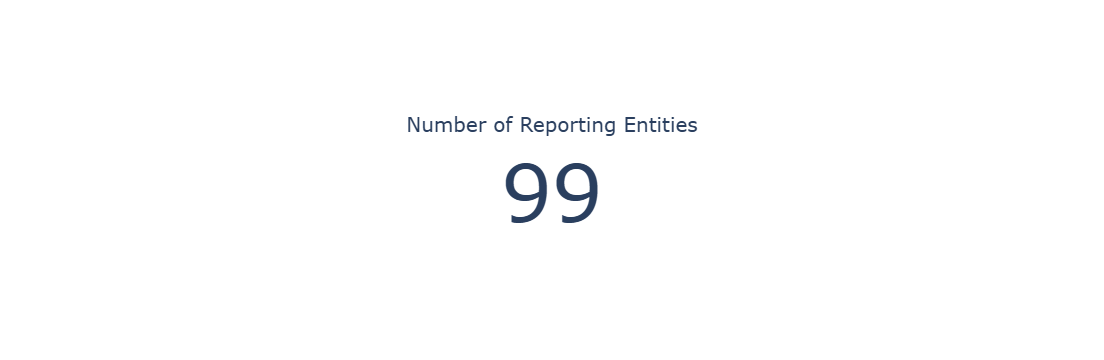

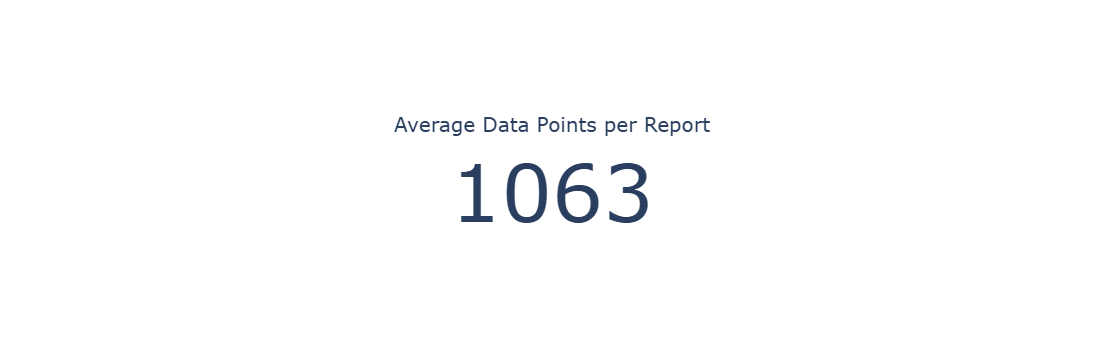

In [7]:
# --- 1. Number of Entities ---
num_entities = df['Company_Symbol'].nunique()
fig_entities = go.Figure(go.Indicator(
    mode='number',
    value=num_entities,
    title={'text': 'Number of Reporting Entities'}
))
fig_entities.show()

# --- 2. Average datapoints per report ---
report_counts = df.groupby(['Company_Symbol', 'Fiscal_Year']).size().reset_index(name='rows')
avg_datapoints = report_counts['rows'].mean()

fig_dp = go.Figure(go.Indicator(
    mode='number',
    value=round(avg_datapoints, 0),
    title={'text': 'Average Data Points per Report'}
))
fig_dp.show()


## Reporting Scope (Consolidated vs Standalone)

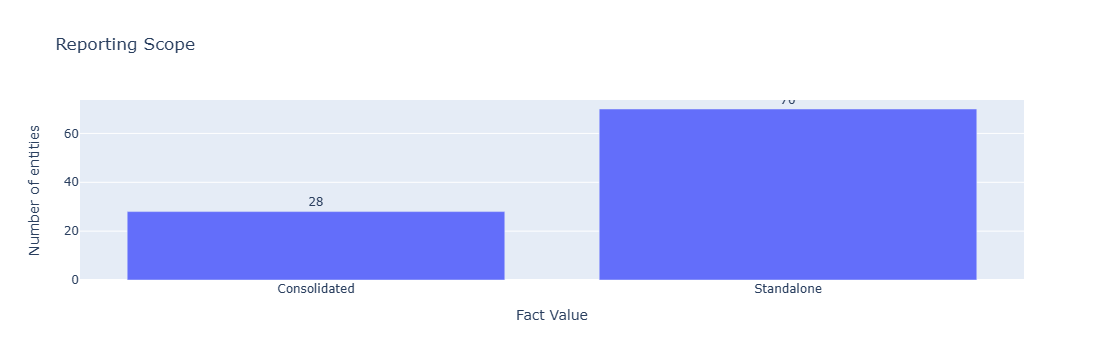

In [8]:
# --- 3. Reporting Scope (Consolidated vs Standalone) ---

scope_series = (df[df['Element Name'] == 'ReportingBoundary']
                ['Fact Value']
                .str.strip()
                .replace({'Consolidated basis':'Consolidated',
                          'Standalone basis':'Standalone'})
                .value_counts()
                .sort_index())

fig_scope = px.bar(
    scope_series,
    x=scope_series.index,
    y=scope_series.values,
    labels={'x':'Scope', 'y':'Number of entities'},
    text=scope_series.values,
    title='Reporting Scope'
)
fig_scope.update_traces(textposition='outside')
fig_scope.show()


## 4. Material Issues Word Frequency (top 30)

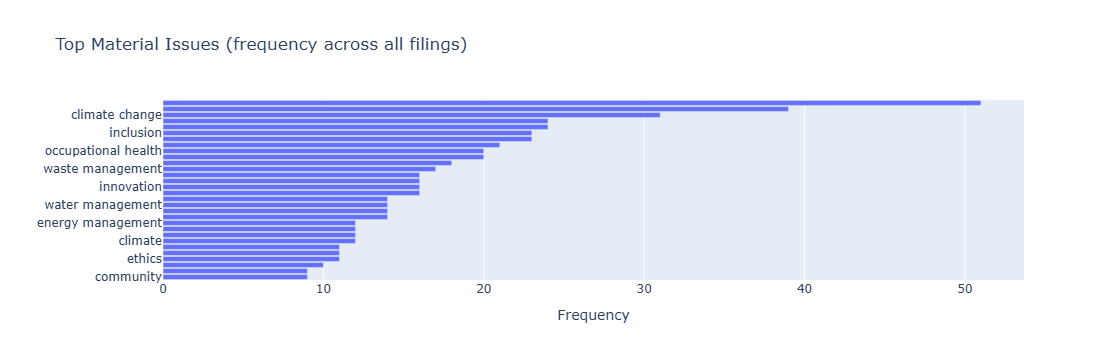

In [9]:
# --- 4. Material Issues Word Frequency (top 30) ---

issues_raw = df[df['Element Name'] == 'MaterialIssueIdentified']['Fact Value'].dropna()

def split_issues(text):
    # Replace common delimiters with commas, then split
    for delim in ['\n', '\r', '\t', ';', '&', '/']:
        text = text.replace(delim, ',')
    # handle ' and ' 
    text = text.replace(' and ', ',')
    return [i.strip().lower() for i in text.split(',') if i.strip()]

from collections import Counter
counter = Counter()
issues_raw.apply(lambda x: counter.update(split_issues(str(x))))

issues_df = pd.DataFrame(counter.most_common(30), columns=['Issue','Count'])

fig_mat = px.bar(
    issues_df,
    x='Count',
    y='Issue',
    orientation='h',
    title='Top Material Issues (frequency across all filings)',
    labels={'Count':'Frequency','Issue':''}
)
fig_mat.update_layout(yaxis={'categoryorder':'total ascending'})
fig_mat.show()


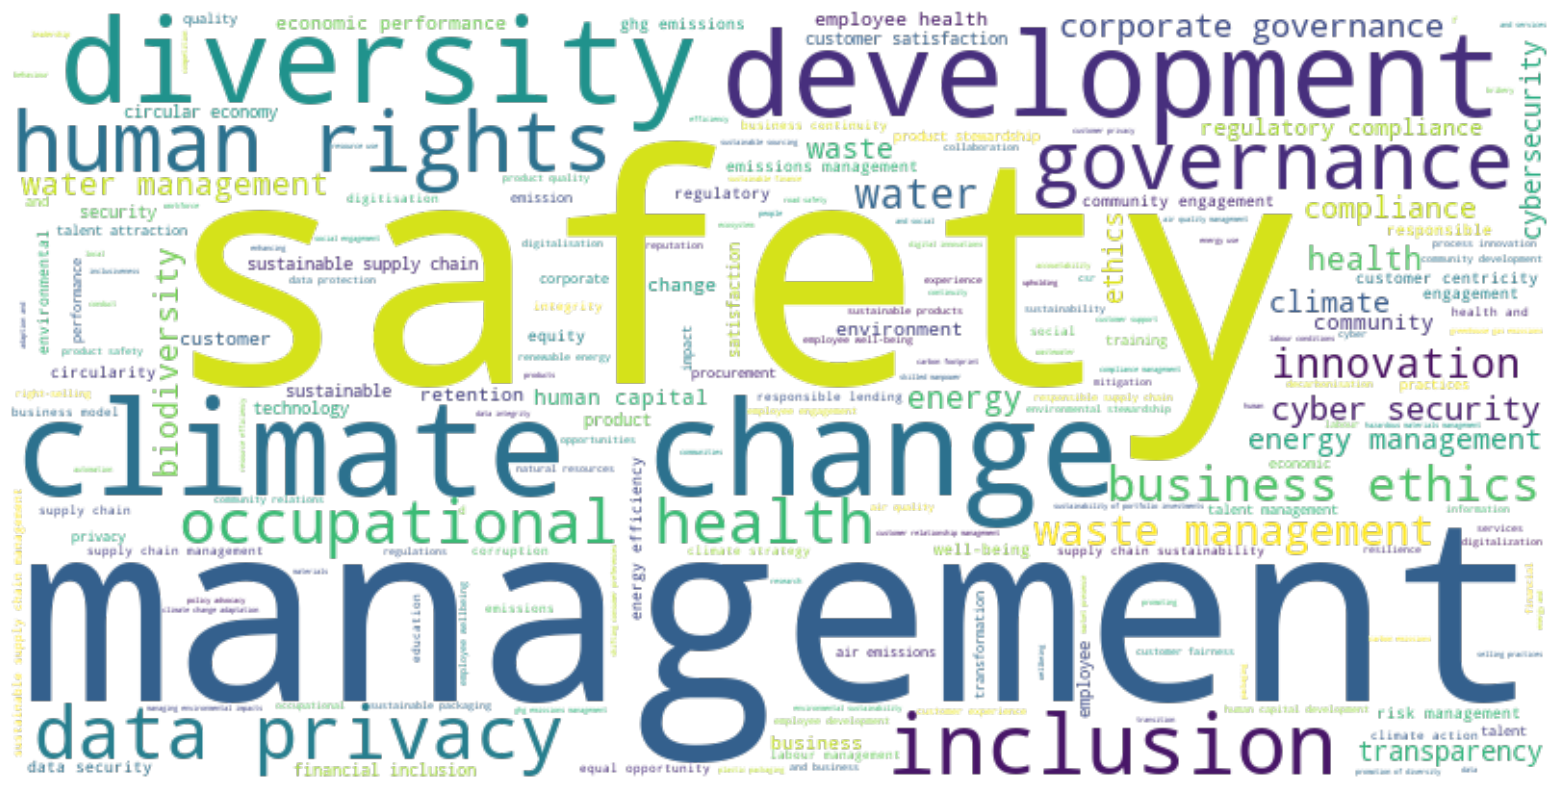

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Recompute issue frequencies from df
# Assumes df is already loaded and 'Fact Value' is present
issues_raw = df[df['Element Name'] == 'MaterialIssueIdentified']['Fact Value'].dropna()

def split_issues(text):
    for delim in ['\n', '\r', '\t', ';', '&', '/']:
        text = text.replace(delim, ',')
    text = text.replace(' and ', ',')
    return [i.strip().lower() for i in text.split(',') if i.strip()]

counter = Counter()
issues_raw.apply(lambda x: counter.update(split_issues(str(x))))

# Generate the word cloud
wc = WordCloud(width=800, height=400, background_color=None, mode='RGBA')\
    .generate_from_frequencies(counter)

# Display
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


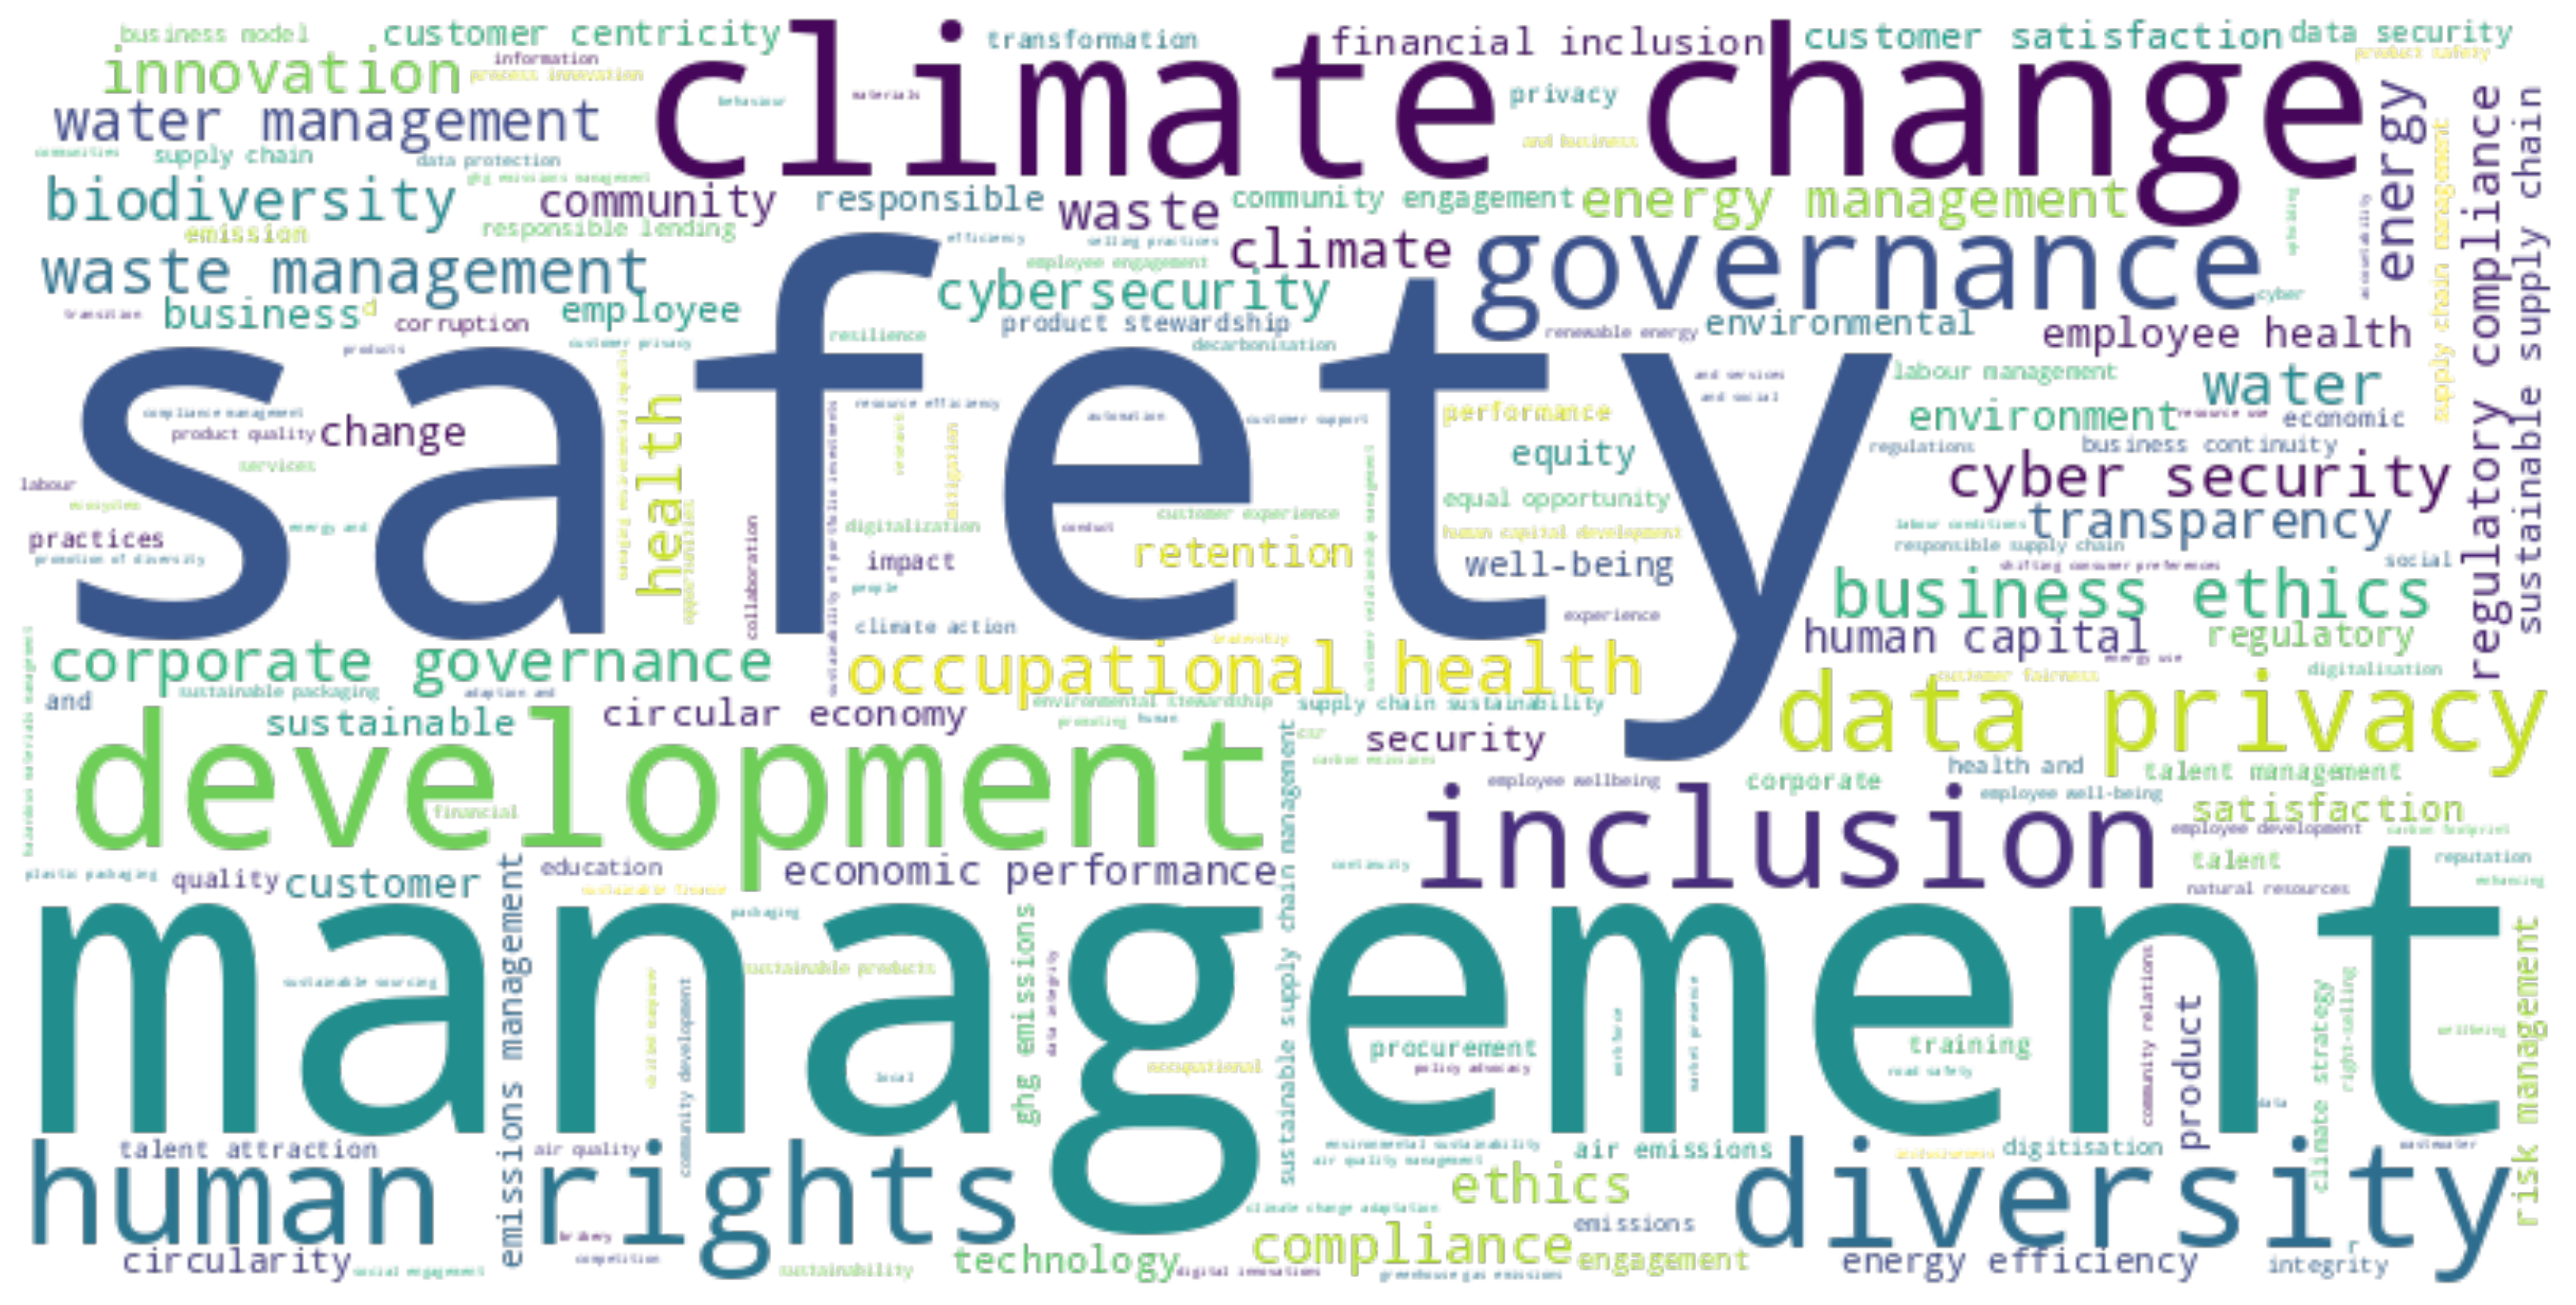

## 5. Macro‑economic Sector – number of reporting entities

In [11]:
# ─── 5 · Macro-economic Sector – number of reporting entities ────────────────
import os
import plotly.express as px
import pandas as pd

# ── 5-A) Try auto-detecting any element that *looks* like a sector field
sector_elements = [
    e for e in df['Element Name'].dropna().unique()
    if 'sector' in str(e).lower()    # matches “sector”, case-insensitive
]

if sector_elements:
    # Use the first match … change this if you want something more specific
    sector_element_name = sector_elements[0]
    print(f"✓ Using element “{sector_element_name}” found in the data.")

    sector_counts = (
        df[df['Element Name'] == sector_element_name]
          .groupby('Fact Value')['Company_Symbol']
          .nunique()
          .sort_values(ascending=False)
          .reset_index(name='Entities')
    )

# ── 5-B) Fallback → external mapping {Company_Symbol → Sector}
else:
    mapping_path = '../input/company_sector_mapping/company_sector_mapping.csv'  # ← adjust if needed

    if not os.path.exists(mapping_path):
        # Nothing found → inform & skip plotting
        print(
            "⚠️  No sector element detected in the BRSR file *and* no mapping file found.\n"
            "    To enable this chart, create a two-column CSV called\n"
            f"    {os.path.basename(mapping_path)}  with:  Company_Symbol  ,  Sector\n"
            "    and add it to your Kaggle dataset. Skipping this plot for now."
        )
        sector_counts = pd.DataFrame(columns=['Sector', 'Entities'])

    else:
        map_df = (pd.read_csv(mapping_path)
                    .dropna(subset=['Company_Symbol', 'Sector'])
                    .astype({'Company_Symbol': 'string', 'Sector': 'string'}))

        sector_counts = (
            df[['Company_Symbol']].drop_duplicates()
              .merge(map_df, on='Company_Symbol', how='left')
              .fillna({'Sector': 'Unknown'})
              .groupby('Sector')['Company_Symbol']
              .nunique()
              .sort_values(ascending=False)
              .reset_index(name='Entities')
        )

# ── Plot (only if we have something to show) ────────────────────────────────
if not sector_counts.empty:
    fig_sector = px.bar(
        sector_counts,
        x='Entities',
        y='Sector',
        orientation='h',
        title='Entities by Macro-economic Sector',
        labels={'Sector': 'Sector', 'Entities': 'Number of entities'}
    )
    fig_sector.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig_sector.show()


⚠️  No sector element detected in the BRSR file *and* no mapping file found.
    To enable this chart, create a two-column CSV called
    company_sector_mapping.csv  with:  Company_Symbol  ,  Sector
    and add it to your Kaggle dataset. Skipping this plot for now.


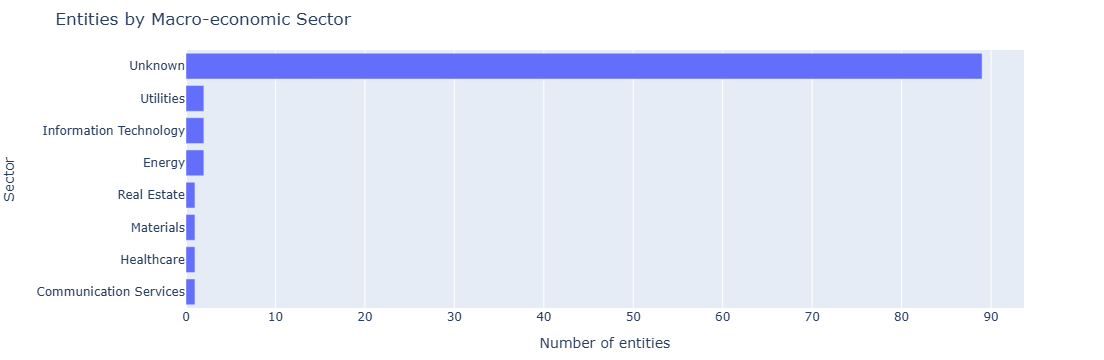

In [12]:
# ─── Cell 5 · Entities by Macro-economic Sector (manual mapping) ───────────────
import pandas as pd
import plotly.express as px

# 1) Define a manual mapping for major companies → sectors
mapping_dict = {
    'RELIANCE':   'Energy',
    'TATASTEEL':  'Materials',
    'ADANIGREEN': 'Utilities',
    'WIPRO':      'Information Technology',
    'JSWENERGY':  'Utilities',
    'BHARTIARTL': 'Communication Services',
    'COALINDIA':  'Energy',
    'CIPLA':      'Healthcare',
    'INFY':       'Information Technology',
    'DLF':        'Real Estate'
}

# 2) Turn it into a DataFrame
map_df = (
    pd.DataFrame.from_dict(mapping_dict, orient='index', columns=['Sector'])
      .reset_index()
      .rename(columns={'index':'Company_Symbol'})
)

# 3) Merge with your unique companies and count per sector
sector_counts = (
    df[['Company_Symbol']].drop_duplicates()
      .merge(map_df, on='Company_Symbol', how='left')
      .fillna({'Sector':'Unknown'})           # any others will fall into "Unknown"
      .groupby('Sector')['Company_Symbol']
      .nunique()
      .reset_index(name='Entities')
      .sort_values('Entities', ascending=False)
)

# 4) Plot horizontally
fig_sector = px.bar(
    sector_counts,
    x='Entities',
    y='Sector',
    orientation='h',
    title='Entities by Macro-economic Sector',
    labels={'Sector':'Sector','Entities':'Number of entities'}
)
fig_sector.update_layout(
    yaxis={'categoryorder':'total ascending'},
    margin=dict(l=120, t=50, b=30)
)
fig_sector.show()


## 6. Energy Sources Split (Fuel / Electricity / Other) per FY


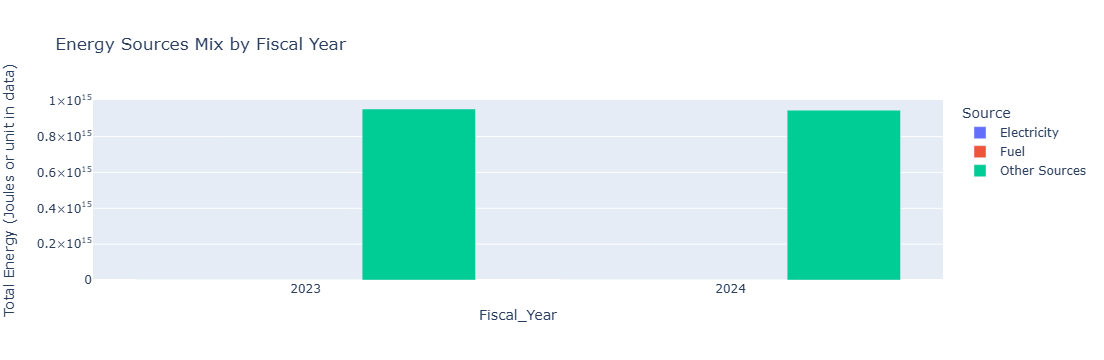

In [13]:
# --- 6. Energy Sources Split (Fuel / Electricity / Other) per FY ---

# Define element names for each source
source_map = {
    'Fuel'      : ['EnergyConsumptionThroughOtherSourcesFromNonRenewableSources'],  # adjust as needed
    'Electricity': ['EnergyConsumptionThroughOtherSourcesFromRenewableSources'],    # adjust as needed
    'Other Sources': ['TotalEnergyConsumedFromRenewableAndNonRenewableSources']     # placeholder
}

energy_list = [item for sub in source_map.values() for item in sub]

energy_df = (df[df['Element Name'].isin(energy_list)]
             .copy()
             .astype({'Fact Value':'float'})
             .rename(columns={'Fact Value':'Value'}))

# Normalize names
energy_df['Source'] = energy_df['Element Name'].map({v: k for k, lst in source_map.items() for v in lst})

summ = (energy_df.groupby(['Fiscal_Year','Source'])['Value']
        .sum()
        .reset_index())

fig_energy = px.bar(
    summ,
    x='Fiscal_Year',
    y='Value',
    color='Source',
    barmode='group',
    title='Energy Sources Mix by Fiscal Year',
    labels={'Value':'Total Energy (Joules or unit in data)'}
)
fig_energy.show()


## 7. Energy Consumption (%) – Renewable vs Non‑renewable (latest FY)

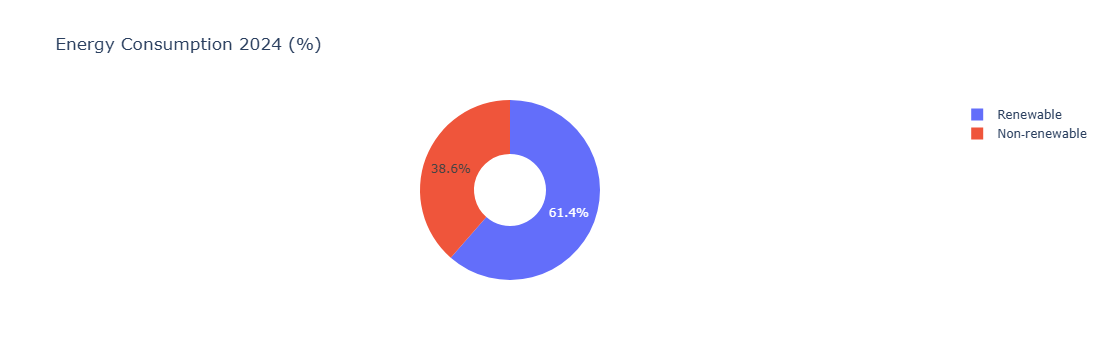

In [14]:
# --- 7. Energy Consumption (%) – Renewable vs Non‑renewable (latest FY) ---

renewable_el  = 'TotalEnergyConsumedFromRenewableSources'
nonrenew_el   = 'TotalEnergyConsumedFromNonRenewableSources'

cons_df = df[df['Element Name'].isin([renewable_el, nonrenew_el])].copy()
cons_df['Fact Value'] = pd.to_numeric(cons_df['Fact Value'], errors='coerce')

latest_year = cons_df['Fiscal_Year'].max()
cons_latest = (cons_df[cons_df['Fiscal_Year']==latest_year]
               .groupby('Element Name')['Fact Value']
               .sum()
               .rename(index={
                   renewable_el:'Renewable',
                   nonrenew_el:'Non‑renewable'
               }))

fig_cons = px.pie(
    cons_latest,
    names=cons_latest.index,
    values=cons_latest.values,
    hole=0.4,
    title=f'Energy Consumption {latest_year} (%)'
)
fig_cons.show()


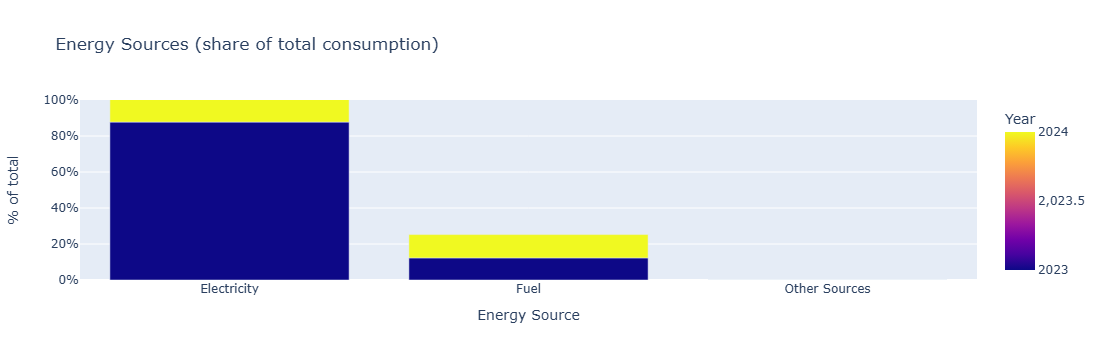

In [15]:
# ─── Cell 1 · Energy Sources (share of total consumption by source) ───────────────────
import pandas as pd
import plotly.express as px

# ensure numeric
df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# Define which raw elements correspond to each source
fuel_els  = ['TotalFuelConsumptionFromRenewableSources', 'TotalFuelConsumptionFromNonRenewableSources']
elec_els  = ['TotalElectricityConsumptionFromRenewableSources', 'TotalElectricityConsumptionFromNonRenewableSources']
other_els = ['EnergyConsumptionThroughOtherSourcesFromRenewableSources', 'EnergyConsumptionThroughOtherSourcesFromNonRenewableSources']

# filter and tag
src = df[df['Element Name'].isin(fuel_els + elec_els + other_els)].copy()
src['Source'] = src['Element Name'].map(
    lambda x: 'Fuel'         if x in fuel_els
              else 'Electricity' if x in elec_els
              else 'Other Sources'
)

# aggregate and percent
agg = (src.groupby(['Fiscal_Year','Source'])['Fact Value']
          .sum()
          .reset_index())
totals = agg.groupby('Fiscal_Year')['Fact Value'].transform('sum')
agg['Pct'] = agg['Fact Value'] / totals * 100

# plot
fig = px.bar(
    agg,
    x='Source', y='Pct', color='Fiscal_Year',
    barmode='group',
    labels={'Pct':'% of total','Source':'Energy Source','Fiscal_Year':'Year'},
    title='Energy Sources (share of total consumption)'
)
fig.update_yaxes(range=[0,100], ticksuffix='%')
fig.show()


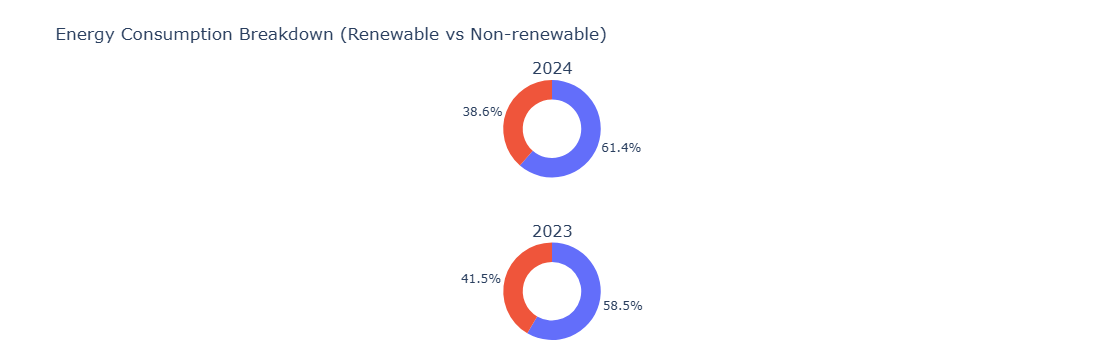

In [16]:
# ─── Cell 2 · Energy Consumption (renewable vs non-renewable donut) ───────────────────
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# element names
ren  = 'TotalEnergyConsumedFromRenewableSources'
non  = 'TotalEnergyConsumedFromNonRenewableSources'

# sum per year
ec = (df[df['Element Name'].isin([ren,non])]
        .groupby(['Fiscal_Year','Element Name'])['Fact Value']
        .sum()
        .reset_index())
ec['Type'] = ec['Element Name'].map({ren:'Renewable', non:'Non-renewable'})

# pivot to get percentages
pv = ec.pivot(index='Fiscal_Year', columns='Type', values='Fact Value').fillna(0)
pv['Total'] = pv.sum(axis=1)
pv['Renewable_Pct']     = pv['Renewable']     / pv['Total'] * 100
pv['Non-renewable_Pct'] = pv['Non-renewable'] / pv['Total'] * 100

# grab two most recent years
years = sorted(pv.index)[-2:]

# build subplots
fig2 = make_subplots(rows=2, cols=1, specs=[[{'type':'domain'}],[{'type':'domain'}]],
                     subplot_titles=[f"{y}" for y in reversed(years)])
for i, yr in enumerate(reversed(years), start=1):
    fig2.add_trace(
        go.Pie(
            labels=['Non-renewable','Renewable'],
            values=[pv.loc[yr,'Non-renewable_Pct'], pv.loc[yr,'Renewable_Pct']],
            hole=0.6,
            textinfo='percent',
            hovertemplate='%{label}: %{percent:.1%}<extra></extra>'
        ),
        row=i, col=1
    )

fig2.update_layout(title_text='Energy Consumption Breakdown (Renewable vs Non-renewable)',
                   showlegend=False, margin=dict(t=80,b=20))
fig2.show()


## 8. GHG Emissions – Scope 1/2/3 per FY

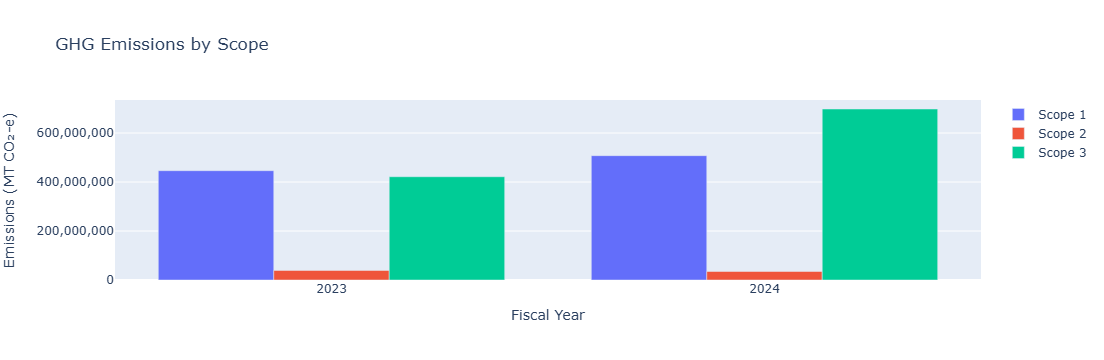

In [17]:
# ─── Cell 8 · GHG Emissions – Scope 1/2/3 per FY ────────────────────────────────
import pandas as pd
import plotly.express as px

# 1) Make sure Fact Value is numeric
df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# 2) Define your mapping of scopes → element names
scope_map = {
    'Scope 1': 'TotalScope1Emissions',
    'Scope 2': 'TotalScope2Emissions',
    'Scope 3': 'TotalScope3Emissions'
}

# 3) Filter and tag
ghg_df = df[df['Element Name'].isin(scope_map.values())].copy()
ghg_df['Scope'] = ghg_df['Element Name'].map({v: k for k, v in scope_map.items()})

# 4) Aggregate by fiscal year & scope
ghg_sum = (
    ghg_df
      .groupby(['Fiscal_Year', 'Scope'])['Fact Value']
      .sum()
      .reset_index()
)

# 5) Plot
fig_ghg = px.bar(
    ghg_sum,
    x='Fiscal_Year',
    y='Fact Value',
    color='Scope',
    barmode='group',
    title='GHG Emissions by Scope',
    labels={
        'Fiscal_Year': 'Fiscal Year',
        'Fact Value': 'Emissions (MT CO₂-e)',
        'Scope': 'GHG Scope'
    }
)
fig_ghg.update_layout(
    yaxis_tickformat=',.0f',
    legend_title_text=''
)
fig_ghg.show()


## 9 Independent assessment or evaluation or assurance

In [18]:
import re

# 1) List out all element names so you can inspect what’s available
elems = df['Element Name'].dropna().unique().tolist()
print("→ Total unique Element Names:", len(elems))
# show only those containing “report” or “assur”
print("\nReporting candidates:", [e for e in elems if re.search(r'report', e, re.IGNORECASE)])
print("\nAssurance candidates:", [e for e in elems if re.search(r'assur', e, re.IGNORECASE)])

# 2) Define your human-readable topics in the order you want them plotted
topics = [
    'Areas of water stress',
    'Energy Consumption',
    'Green House Gas Emissions',
    'Other than GHG emissions',
    'Scope 3 Emissions',
    'Waste Management',
    'Water discharged',
    'Water Withdrawal'
]

# 3) For each topic, try to pick the best matching element names
mapping = []
for t in topics:
    key = re.sub(r'[^A-Za-z0-9]', '', t).lower()
    # pick first elem that has both the topic key & “assur”
    ass = next((e for e in elems
                if key in re.sub(r'[^A-Za-z0-9]', '', e).lower()
                   and 'assur' in e.lower()), None)
    # pick first elem that has both the topic key & “report”
    rep = next((e for e in elems
                if key in re.sub(r'[^A-Za-z0-9]', '', e).lower()
                   and 'report' in e.lower()), None)
    mapping.append((t, ass, rep))
    
# show the auto-detected mapping for you to verify
print("\nAuto-detected mapping (Topic, AssuranceElement, ReportingElement):")
for row in mapping:
    print("  ", row)


→ Total unique Element Names: 1042

Reporting candidates: ['ReportingBoundary', 'WhetherDetailsOfFinancialYearForWhichReportingIsBeingDoneIsAssuredByAssurer', 'AssuranceSubTypeForDetailsOfFinancialYearForWhichReportingIsBeingDone', 'WhetherNameAndContactDetailsOfTheContactPersonInCaseOfAnyQueriesOnTheBRSRReportIsAssuredByAssurer', 'AssuranceSubTypeForNameAndContactDetailsOfTheContactPersonInCaseOfAnyQueriesOnTheBRSRReport', 'WhetherReportingBoundaryIsAssuredByAssurer', 'AssuranceSubTypeForReportingBoundary', 'WhetherStatementByDirectorResponsibleForTheBusinessResponsibilityReportHighlightingESGRelatedChallengesTargetsAndAchievementsIsAssuredByAssurer', 'AssuranceSubTypeForStatementByDirectorResponsibleForTheBusinessResponsibilityReportHighlightingESGRelatedChallengesTargetsAndAchievements', 'StatementByDirectorResponsibleForTheBusinessResponsibilityReportHighlightingESGRelatedChallengesTargetsAndAchievementsExplanatoryTextBlock', 'WhetherYouHaveProcessesForWorkersToReportTheWorkRelated

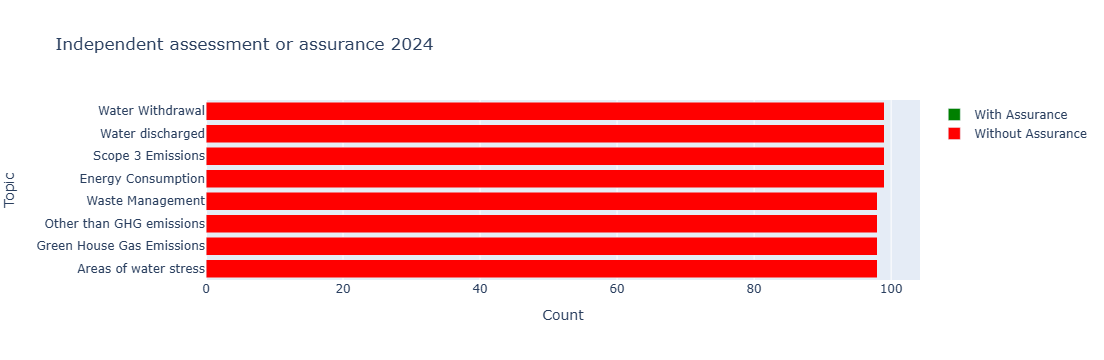

In [19]:
# ─── Cell 2 · Independent assessment or assurance chart ─────────────
import re
import pandas as pd
import plotly.express as px

# 1) Grab the latest year
latest = df['Fiscal_Year'].max()

# 2) Map each topic to its “independent assessment or assurance” element-name
map_df = [
    ('Areas of water stress',
     'IndicateIfAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForAreasOfWaterStress',
     None),
    ('Energy Consumption',
     'WhetherAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForEnergyConsumptionUnderLeadershipIndicators',
     None),
    ('Green House Gas Emissions',
     'WhetherAnyIndicateIfAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForGreenHouseGasEmissions',
     None),
    ('Other than GHG emissions',
     'IndicateIfAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForAirEmissionsOtherThanGHGEmissions',
     None),
    ('Scope 3 Emissions',
     'WhetherAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForTotalScope3Emissions',
     None),
    ('Waste Management',
     'WhetherAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForWasteManagement',
     None),
    ('Water discharged',
     'WhetherAnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForWaterDischarged',
     None),
    ('Water Withdrawal',
     'AnyIndependentAssessmentOrEvaluationOrAssuranceHasBeenCarriedOutByAnExternalAgencyForWaterWithdrawal',
     None)
]

# 3) Build the “with” vs “without” counts
rows = []
for topic, ass_el, rep_el in map_df:
    # sum up all “with assurance” flags (1’s) for this topic
    with_assur = df.loc[
        (df['Fiscal_Year'] == latest) &
        (df['Element Name'] == ass_el),
        'Fact Value'
    ].sum()

    # determine total reporters via a loose keyword match on topic
    key = re.sub(r'[^A-Za-z0-9]', '', topic).lower()
    total = df.loc[
        (df['Fiscal_Year'] == latest) &
        (df['Element Name'].str.contains(key, case=False, regex=False)),
        'Company_Symbol'
    ].nunique()

    rows.append({
        'Topic': topic,
        'With Assurance': with_assur,
        'Without Assurance': max(total - with_assur, 0)
    })

plot_df = (
    pd.DataFrame(rows)
      .melt(id_vars='Topic',
            value_vars=['With Assurance','Without Assurance'],
            var_name='Status',
            value_name='Count')
)

# 4) Render the stacked‐bar
fig = px.bar(
    plot_df,
    x='Count',
    y='Topic',
    color='Status',
    orientation='h',
    title=f'Independent assessment or assurance {latest}',
    color_discrete_map={'With Assurance':'green','Without Assurance':'red'}
)
fig.update_layout(
    barmode='stack',
    yaxis={'categoryorder':'total ascending'},
    legend_title_text=''
)
fig.show()


## 10. Waste Generated vs Disposed vs Recovered (last 2 FYs)

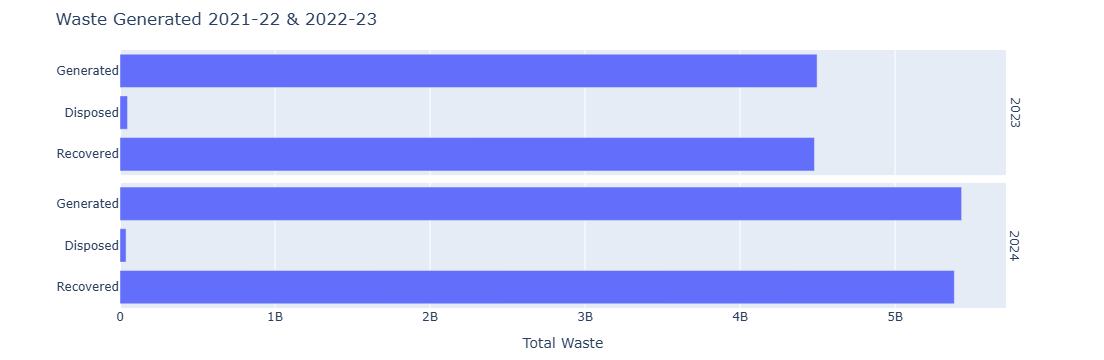

In [20]:
# ─── Cell 9 · Waste Generated vs Disposed vs Recovered (last 2 FYs) ─────────────
import pandas as pd
import plotly.express as px

# 1) ensure Fact Value is numeric
df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# 2) map your waste elements
waste_map = {
    'Generated': 'TotalWasteGenerated',
    'Disposed':  'TotalWasteDisposed',
    'Recovered': 'TotalWasteRecovered'
}
w = df[df['Element Name'].isin(waste_map.values())].copy()
w['Type'] = w['Element Name'].map({v: k for k, v in waste_map.items()})

# 3) pick the last two years and aggregate
years = sorted(w['Fiscal_Year'].unique())[-2:]
agg = (
    w[w['Fiscal_Year'].isin(years)]
      .groupby(['Fiscal_Year', 'Type'])['Fact Value']
      .sum()
      .reset_index()
)

# 4) order the types
agg['Type'] = pd.Categorical(agg['Type'],
                             categories=['Generated','Disposed','Recovered'],
                             ordered=True)

# 5) draw facet_row bars
fig = px.bar(
    agg,
    x='Fact Value',
    y='Type',
    orientation='h',
    facet_row='Fiscal_Year',
    category_orders={'Type': ['Generated','Disposed','Recovered'],
                     'Fiscal_Year': years},
    labels={'Fact Value': 'Total Waste','Type': ''},
    title='Waste Generated 2021-22 & 2022-23'
)
fig.update_layout(
    showlegend=False,
    margin=dict(t=50, l=120, b=30),
)
# clean up the “Fiscal_Year=2022-23” annotation to just “2022-23”
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
fig.update_xaxes(matches='x')  # share x-axis scale
fig.show()


## 11. Entities reporting **Essential** Indicators

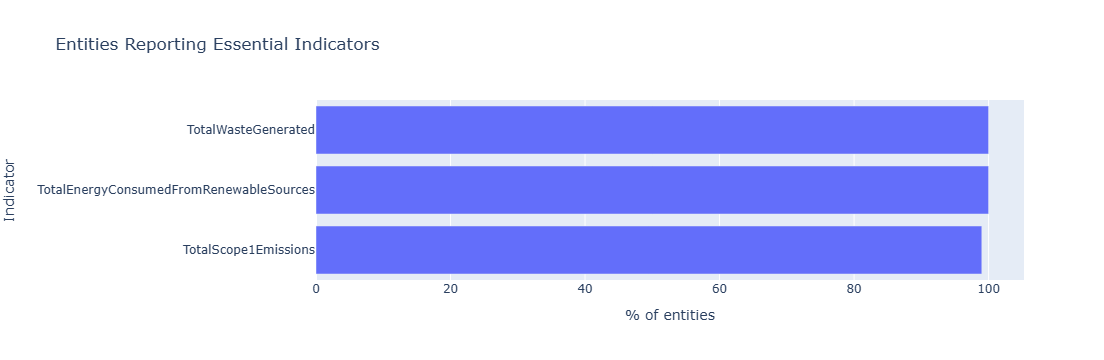

In [21]:
# --- 11. Entities reporting **Essential** Indicators ---

# List the element names for essential indicators as per BRSR Core (customize)
essential_indicators = [
    'TotalEnergyConsumedFromRenewableSources',
    'TotalScope1Emissions',
    'TotalWasteGenerated'
]

essential_df = df[df['Element Name'].isin(essential_indicators)]

pivot = (essential_df
         .groupby(['Element Name','Company_Symbol'])
         .size()
         .unstack(fill_value=0)
         .astype(bool))

pct_reporting = (pivot.sum(axis=1) / df['Company_Symbol'].nunique() * 100).sort_values(ascending=False)

fig_ess = px.bar(
    pct_reporting,
    x=pct_reporting.values,
    y=[e.split('/')[-1] for e in pct_reporting.index],
    orientation='h',
    title='Entities Reporting Essential Indicators',
    labels={'x':'% of entities','y':'Indicator'}
)
fig_ess.update_layout(yaxis={'categoryorder':'total ascending'})
fig_ess.show()


## Specific measures for 2024

In [22]:
# ─── Cell · Specific Measures 2022-2023 ────────────────────────────────────────

import pandas as pd

# 1) Make sure Fact Value is numeric
df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# 2) Map the human-readable labels to the exact Element Name codes in combined_brsr_data.csv
measure_map = {
    '% of inputs were sourced sustainably':
        'PercentageOfInputsWereSourcedSustainably',
    '% of sourced directly from within the district and neighbouring districts':
        'PercentageOfSourcedDirectlyFromWithinTheDistrictAndNeighbouringDistricts',
    '% of R&D in envt and social impacts':
        'PercentageOfRAndD',
    '% of Reclaimed Products and Packaging':
        'ReclaimedProductsAndTheirPackagingMaterialsAsPercentageOfTotalProductsSoldInRespectiveCategory',
    '% of Recycled or reused input materials':
        'RecycledOrReUsedInPutMaterialToTotalMaterial',
    '% of directly sourced from MSMEs or small producers':
        'PercentageOfDirectlySourcedFromMSMEsOrSmallProducers',
    '% of CAPEX in envt and social impacts':
        'PercentageOfCapex'
}

# 3) Aggregate for the latest fiscal year
latest = df['Fiscal_Year'].max()
rows = []
for label, elem in measure_map.items():
    val = df.loc[
        (df['Fiscal_Year'] == latest) &
        (df['Element Name']   == elem),
        'Fact Value'
    ].sum()
    rows.append({'Measure': label, 'Value (%)': val})

measures_df = (
    pd.DataFrame(rows)
      .sort_values('Value (%)', ascending=False)
      .reset_index(drop=True)
)

# 4) Display the results
print(f"Specific measures for {latest}\n")
display(measures_df)


Specific measures for 2024



Measure  Value (%)
0  % of sourced directly from within the district...    67.8004
1               % of inputs were sourced sustainably    46.7056
2                % of R&D in envt and social impacts    26.7523
3              % of Reclaimed Products and Packaging    22.0514
4              % of CAPEX in envt and social impacts    20.8138
5  % of directly sourced from MSMEs or small prod...    18.3765
6            % of Recycled or reused input materials    17.6479

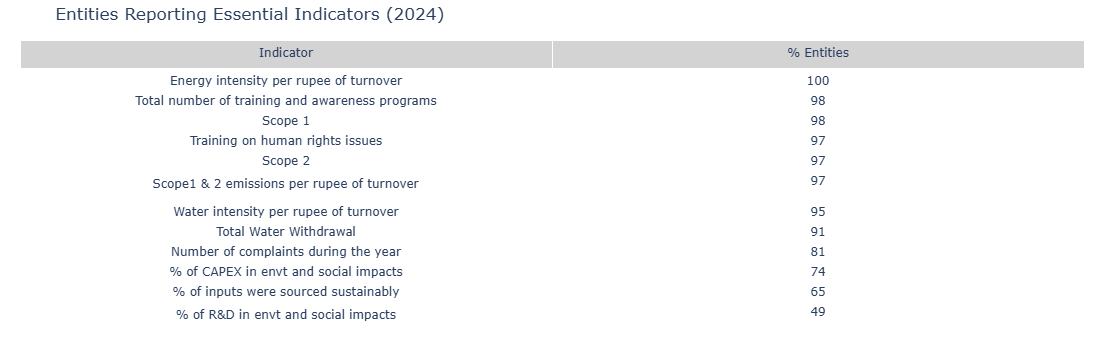

In [23]:
# Essential Indicators – % of entities reporting a non-zero value
import pandas as pd
import plotly.graph_objects as go

# 1) Map labels → raw element names
essential_map = {
    'Total number of training and awareness programs':
        'TotalNumberOfTrainingAndAwarenessProgramsHeld',
    'Training on human rights issues':
        'NumberOfEmployeesOrWorkersCoveredForProvidedTrainingOnHumanRightsIssues',
    'Total Water Withdrawal':
        'TotalVolumeOfWaterWithdrawal',
    'Number of complaints during the year':
        'NumberOfComplaintsFiledDuringTheYear',
    'Scope 1':
        'TotalScope1Emissions',
    'Scope 2':
        'TotalScope2Emissions',
    'Energy intensity per rupee of turnover':
        'EnergyIntensityPerRupeeOfTurnover',
    '% of inputs were sourced sustainably':
        'PercentageOfInputsWereSourcedSustainably',
    'Entity has implemented a mechanism for zero liquid discharge':
        'HasTheEntityImplementedAMechanismForZeroLiquidDischarge',
    'Water intensity per rupee of turnover':
        'WaterIntensityPerRupeeOfTurnover',
    '% of CAPEX in envt and social impacts':
        'PercentageOfCapex',
    'Scope1 & 2 emissions per rupee of turnover':
        'TotalScope1AndScope2EmissionsIntensityPerRupeeOfTurnover',
    '% of R&D in envt and social impacts':
        'PercentageOfRAndD'
}

# 2) Compute “% of entities” for each indicator
total_entities = df['Company_Symbol'].nunique()
rows = []
for label, elem in essential_map.items():
    count = (
        df.loc[
            (df['Fiscal_Year'] == latest) &
            (df['Element Name']  == elem) &
            (df['Fact Value']     > 0),
            'Company_Symbol'
        ]
        .nunique()
    )
    pct = count / total_entities * 100
    if count > 0:
        rows.append((label, pct))

ess_df = (
    pd.DataFrame(rows, columns=['Indicator','Pct'])
      .sort_values('Pct', ascending=False)
      .reset_index(drop=True)
)

# 3) Render as a table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Indicator','% Entities'], fill_color='lightgrey'),
    cells=dict(values=[ess_df['Indicator'], ess_df['Pct'].round(0)],
               fill_color='white'))
])
fig.update_layout(
    title_text=f'Entities Reporting Essential Indicators ({latest})',
    margin=dict(t=40,l=20,r=20,b=20)
)
fig.show()


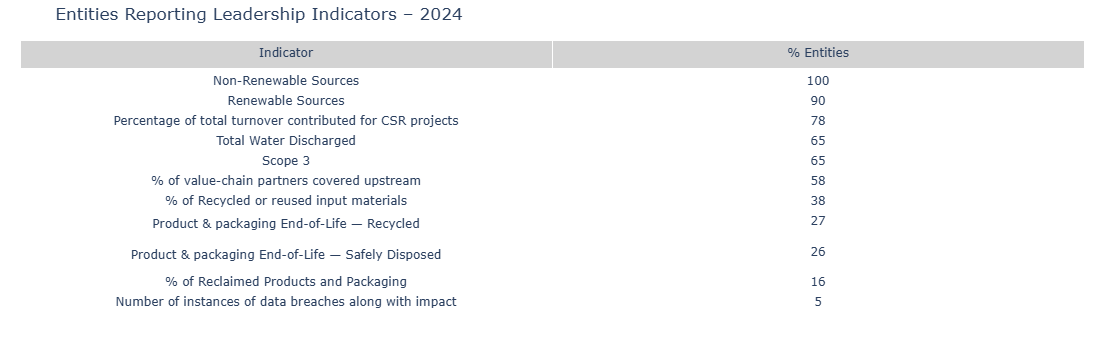

In [24]:
df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# 2) Map human labels → actual Element Name codes in the CSV
leadership_map = {
    'Non-Renewable Sources':
        'TotalEnergyConsumedFromNonRenewableSources',
    'Renewable Sources':
        'TotalEnergyConsumedFromRenewableSources',
    '% of value-chain partners covered upstream':
        'PercentageOfValueChainPartnersCoveredUnderTheAwarenessProgrammes',
    'Total Water Discharged':
        'TotalWaterDischargedInKilolitres',
    '% of Recycled or reused input materials':
        'RecycledOrReUsedInPutMaterialToTotalMaterial',
    'Scope 3':
        'TotalScope3Emissions',
    'Product & packaging End-of-Life — Safely Disposed':
        'AmountOfSafelyDisposed',
    'Product & packaging End-of-Life — Recycled':
        'AmountOfRecycled',
    'Percentage of total turnover contributed for CSR projects':
        'AmountSpentForCSRProjectsUndertaken',
    '% of Reclaimed Products and Packaging':
        'ReclaimedProductsAndTheirPackagingMaterialsAsPercentageOfTotalProductsSoldInRespectiveCategory',
    'Number of instances of data breaches along with impact':
        'NumberOfInstancesOfDataBreachesAlongWithImpact'
}

# 3) Compute “% of entities reporting a non-zero” for the latest year
latest = df['Fiscal_Year'].max()
total_entities = (
    df.loc[df['Fiscal_Year'] == latest, 'Company_Symbol']
      .nunique()
)

rows = []
for label, elem in leadership_map.items():
    if elem not in df['Element Name'].unique():
        # skip any mappings that really don't exist
        continue
    sub = df[
        (df['Fiscal_Year'] == latest) &
        (df['Element Name'] == elem)
    ]
    # count unique companies with a numeric value > 0
    count = sub.loc[sub['Fact Value'] > 0, 'Company_Symbol'].nunique()
    pct   = count / total_entities * 100
    if count > 0:
        rows.append((label, round(pct, 0)))

lead_df = (
    pd.DataFrame(rows, columns=['Indicator','% Entities'])
      .sort_values('% Entities', ascending=False)
      .reset_index(drop=True)
)

# 4) Render as a table
fig = go.Figure(
    data=[go.Table(
        header=dict(values=['Indicator','% Entities'], fill_color='lightgrey'),
        cells =dict(
            values=[lead_df['Indicator'], lead_df['% Entities']],
            fill_color='white'
        )
    )]
)
fig.update_layout(
    title_text=f'Entities Reporting Leadership Indicators – {latest}',
    margin=dict(t=40, l=20, r=20, b=20)
)
fig.show()

# Employment Metrics

## Median Salary 

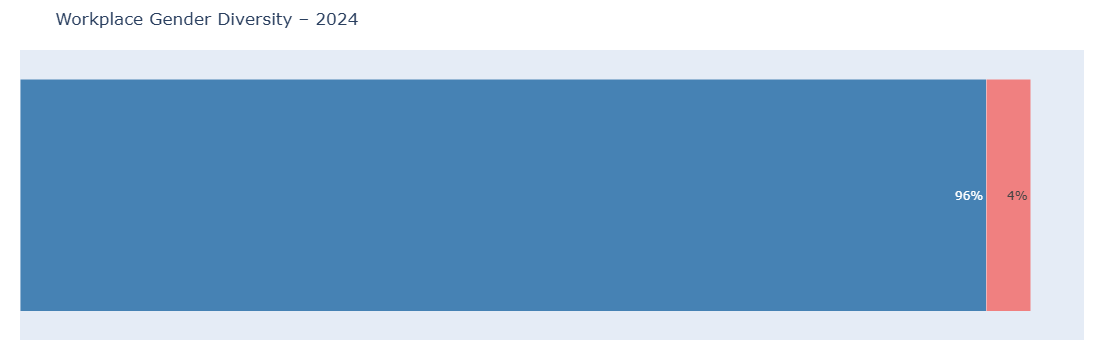

In [25]:

df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')
latest = df['Fiscal_Year'].max()

# 2) Pull female & total workforce counts
female_el = 'NumberOfFemaleEmployeesOrWorkers'
total_el  = 'NumberOfEmployeesOrWorkersIncludingDifferentlyAbled'

female_count = df.loc[
    (df['Fiscal_Year'] == latest) &
    (df['Element Name'] == female_el),
    'Fact Value'
].sum()

total_count = df.loc[
    (df['Fiscal_Year'] == latest) &
    (df['Element Name'] == total_el),
    'Fact Value'
].sum()

male_count   = total_count - female_count
male_pct     = male_count / total_count * 100 if total_count else 0
female_pct   = female_count / total_count * 100 if total_count else 0

# 3) Plot single 100%-stacked bar
fig = go.Figure()
fig.add_trace(go.Bar(
    x=[male_pct],
    y=['Workforce'],
    orientation='h',
    name='Male',
    marker_color='steelblue',
    text=[f"{male_pct:.0f}%"],
    textposition='inside'
))
fig.add_trace(go.Bar(
    x=[female_pct],
    y=['Workforce'],
    orientation='h',
    name='Female',
    marker_color='lightcoral',
    text=[f"{female_pct:.0f}%"],
    textposition='inside'
))

fig.update_layout(
    barmode='stack',
    title_text=f'Workplace Gender Diversity – {latest}',
    xaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    showlegend=False,
    margin=dict(t=50, l=20, r=20, b=20)
)

fig.show()


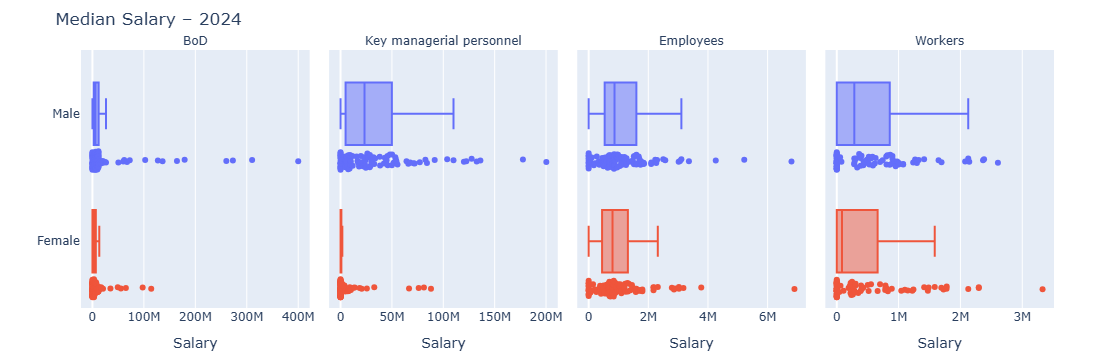

In [26]:
df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')
latest = df['Fiscal_Year'].max()

# 2) Map each group → its median‐salary element name
median_map = {
    'BoD':       'MedianOfRemunerationOrSalaryOrWagesOfBoardOfDirectors',
    'Key managerial personnel':
                 'MedianOfRemunerationOrSalaryOrWagesOfKeyManagerialPersonnel',
    'Employees':
                 'MedianOfRemunerationOrSalaryOrWagesOfEmployeesOtherThanBodAndKMP',
    'Workers':   'MedianOfRemunerationOrSalaryOrWagesOfWorkers'
}

# 3) Extract a long DataFrame of (Group, Gender, Salary)
rows = []
for group, elem in median_map.items():
    sub = df[
        (df['Fiscal_Year'] == latest) &
        (df['Element Name'] == elem)
    ]
    for _, r in sub.iterrows():
        unit = r['Unit']                # e.g. 'D_Male_p5', 'D_Female_p5'
        parts = unit.split('_')
        if len(parts) >= 2 and parts[1] in ('Male','Female'):
            rows.append({
                'Group':  group,
                'Gender': parts[1],
                'Salary': r['Fact Value']
            })

med_df = pd.DataFrame(rows)

# 4) Plot box + jittered points, faceted by Group
fig = px.box(
    med_df,
    x='Salary',
    y='Gender',
    color='Gender',
    facet_col='Group',
    facet_col_wrap=4,
    points='all',
    title=f'Median Salary – {latest}',
    labels={'Salary':'Salary','Gender':''}
)

# Clean up facet titles (remove "Group=")
for ann in fig.layout.annotations:
    ann.text = ann.text.split('=')[1]

fig.update_layout(
    showlegend=False,
    margin=dict(t=50, l=50, r=50, b=50)
)
fig.for_each_xaxis(lambda ax: ax.update(matches=None))  # keep separate x‐axes
fig.show()

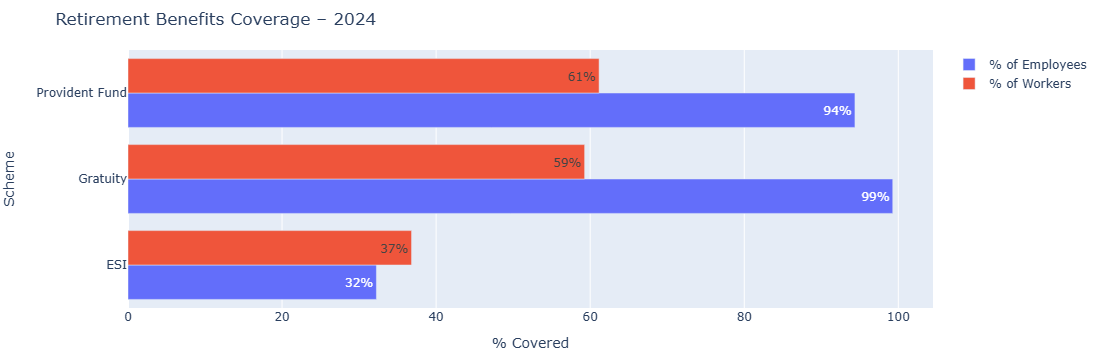

In [27]:

df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')
latest = df['Fiscal_Year'].max()
# Cell · Retirement Benefits Coverage by Scheme
# ——————————————————————————————————————
# Map scheme name → unit code in the CSV
scheme_units = {
    'ESI':            'D_ESI',
    'Gratuity':       'D_Gratuity',
    'Provident Fund': 'D_ProvidentFund'
}

rows = []
for scheme, unit in scheme_units.items():
    # % of employees covered
    emp_vals = df.loc[
        (df.Fiscal_Year == latest) &
        (df.Unit        == unit)    &
        (df['Element Name']=='NumberOfEmployeesCoveredAsPercentageOfTotalEmployees'),
        'Fact Value'
    ].astype(float)
    # % of workers covered
    wrk_vals = df.loc[
        (df.Fiscal_Year == latest) &
        (df.Unit        == unit)    &
        (df['Element Name']=='NumberOfEmployeesCoveredAsPercentageOfTotalWorker'),
        'Fact Value'
    ].astype(float)

    # average across all reporting companies (×100 to get percent)
    pct_emp = emp_vals.mean() * 100 if len(emp_vals) else 0
    pct_wrk = wrk_vals.mean() * 100 if len(wrk_vals) else 0

    rows.append((scheme, pct_emp, pct_wrk))

cov_df = pd.DataFrame(rows, columns=['Scheme','% Employees Covered','% Workers Covered'])

# Plot grouped horizontal bars
fig = go.Figure()
fig.add_trace(go.Bar(
    y=cov_df['Scheme'],
    x=cov_df['% Employees Covered'],
    name='% of Employees',
    orientation='h',
    text=cov_df['% Employees Covered'].round(0).astype(int).astype(str) + '%',
    textposition='inside'
))
fig.add_trace(go.Bar(
    y=cov_df['Scheme'],
    x=cov_df['% Workers Covered'],
    name='% of Workers',
    orientation='h',
    text=cov_df['% Workers Covered'].round(0).astype(int).astype(str) + '%',
    textposition='inside'
))
fig.update_layout(
    barmode='group',
    title_text=f'Retirement Benefits Coverage – {latest}',
    xaxis=dict(title='% Covered'),
    yaxis=dict(title='Scheme'),
    legend_title_text='',
    margin=dict(l=100, t=50, b=50, r=20)
)
fig.show()


In [28]:
# ─── Cell · Discover Retirement Benefits Element Names ────────────────────────
# This will list all Element Names in your BRSR data that mention
# common retirement‐benefit keywords (ESI, Gratuity, Provident, Deduct, Deposit)

import pandas as pd

# Ensure your df is already loaded
# df = pd.read_csv('…/combined_brsr_data.csv')
# df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# Define keywords to search for
keywords = ['esi', 'gratuity', 'provident', 'benefit', 'deduct', 'deposit']

# Find all unique Element Names containing any of these keywords
candidates = sorted({
    e for e in df['Element Name'].dropna().unique()
    if any(kw.lower() in e.lower() for kw in keywords)
})

# Print them out for you to inspect
print("Retirement‐benefits candidates:\n")
for name in candidates:
    print(" ", name)


Retirement‐benefits candidates:

  AssuranceSubTypeForAPreferentialProcurementPolicyWherePreferenceToPurchaseFromSuppliersComprisingMarginalizedOrVulnerableGroupsAndItsPercentageOfTotalProcurementByValueDoesItConstitute
  AssuranceSubTypeForDataBreachesInformationLikeNumberOfInstancesOfDataBreachesAlongWithImpactAndPercentageOfDataBreachesInvolvingPersonallyIdentifiableInformationOfCustomers
  AssuranceSubTypeForDescribeTheProcessesInPlaceToSafelyReclaimYourProductsForReusingRecyclingAndDisposingAtTheEndOfLifeForPlasticsIncludingPackagingEWasteHazardousWasteAndOtherWaste
  AssuranceSubTypeForDetailsOfCSRProjectsUndertakenInDesignatedAspirationalDistrictsAsIdentifiedByGovernmentBodies
  AssuranceSubTypeForDetailsOfMeasuresUndertakenByTheEntityToEnsureThatStatutoryDuesHaveBeenDeductedAndDepositedByTheValueChainPartners
  AssuranceSubTypeForDetailsOfNumberOfLocationsWherePlantsAndOrOperationsOrOfficesOfTheEntityAreSituated
  AssuranceSubTypeForDetailsOfOperationsOrOfficesInOrAroundEcologi

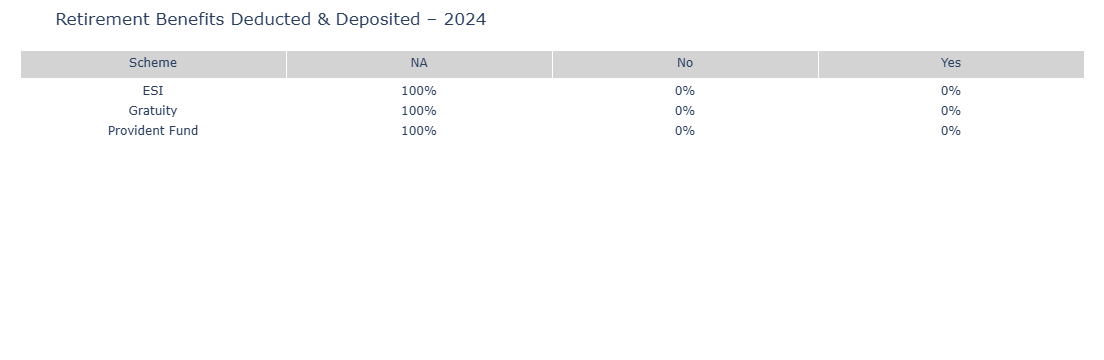

In [29]:
# Cell · Retirement Benefits Deducted & Deposited by Scheme
scheme_units = {
    'ESI':            'D_ESI',
    'Gratuity':       'D_Gratuity',
    'Provident Fund': 'D_ProvidentFund'
}

rows = []
for scheme, unit in scheme_units.items():
    # all companies that reported this scheme
    total_cos = (
        df.loc[
            (df.Fiscal_Year == latest) &
            (df.Unit        == unit),
            'Company_Symbol'
        ]
        .nunique()
    )
    if total_cos == 0:
        continue

    # filter to the “DeductedAndDepositedWithTheAuthority” question
    sub = df.loc[
        (df.Fiscal_Year == latest) &
        (df.Unit        == unit)    &
        (df['Element Name'] == 'DeductedAndDepositedWithTheAuthority'),
        ['Company_Symbol','Fact Value']
    ]

    yes = sub.loc[sub['Fact Value']=='Yes', 'Company_Symbol'].nunique()
    no  = sub.loc[sub['Fact Value']=='No',  'Company_Symbol'].nunique()
    na  = total_cos - yes - no

    rows.append((
        scheme,
        round(na  / total_cos * 100, 0),
        round(no  / total_cos * 100, 0),
        round(yes / total_cos * 100, 0)
    ))

dep_df = pd.DataFrame(rows, columns=['Scheme','NA %','No %','Yes %'])

# render as a table
fig = go.Figure(go.Table(
    header=dict(values=['Scheme','NA','No','Yes'], fill_color='lightgrey'),
    cells =dict(
        values=[
            dep_df['Scheme'],
            dep_df['NA %'].astype(int).astype(str) + '%',
            dep_df['No %'].astype(int).astype(str) + '%',
            dep_df['Yes %'].astype(int).astype(str) + '%'
        ],
        fill_color='white'
    )
))
fig.update_layout(
    title_text=f'Retirement Benefits Deducted & Deposited – {latest}',
    margin=dict(l=20, t=50, b=20, r=20)
)
fig.show()


In [30]:
# Cell · List all complaint-related Element Names
# ————————————————————————————————————————
# Assumes df & latest are already defined

# 1) Find any Element Name containing “complaint” (case-insensitive)
complaint_fields = sorted({
    name for name in df['Element Name'].unique()
    if 'complaint' in name.lower()
})

# 2) Print them out
print("Complaint-related Element Names:")
for f in complaint_fields:
    print(" -", f)


Complaint-related Element Names:
 - AssuranceSubTypeForComplaintsFiledUnderTheSexualHarassmentOfWomenAtWorkplace
 - AssuranceSubTypeForComplaintsOrGrievancesOnAnyOfThePrinciplesUnderTheNationalGuidelinesOnResponsibleBusinessConduct
 - AssuranceSubTypeForDetailsOfABusinessProcessBeingModifiedOrIntroducedAsAResultOfAddressingHumanRightsGrievancesOrComplaints
 - AssuranceSubTypeForDetailsOfComplaintsMadeByEmployeesAndWorkersAsPerP3
 - AssuranceSubTypeForDetailsOfComplaintsMadeByEmployeesAndWorkersAsPerP5
 - AssuranceSubTypeForDetailsOfComplaintsWithRegardToConflictOfInterest
 - AssuranceSubTypeForDetailsOfNumberOfConsumerComplaintsP9
 - AssuranceSubTypeForTheMechanismsInPlaceToReceiveAndRespondToConsumerComplaintsAndFeedback
 - ComplaintsOnPOSHUpHeld
 - ConsumerComplaintsPendingResolutionAtEndOfYear
 - ConsumerComplaintsReceivedDuringTheYear
 - DescribeTheMechanismsInPlaceToReceiveAndRespondToConsumerComplaintsAndFeedbackExplanatoryTextBlock
 - DetailsOfABusinessProcessBeingModifiedOrIntr

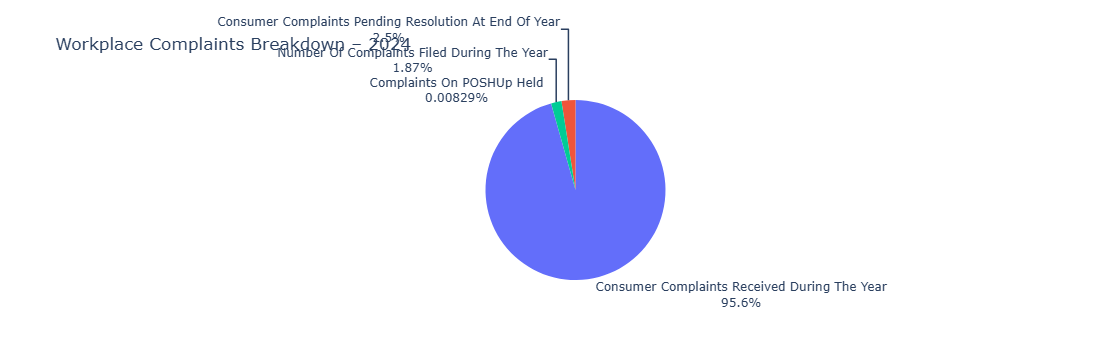

In [31]:
# Cell · Workplace Complaints Breakdown (available metrics)
import re
import pandas as pd
import plotly.express as px

# Assumes you've already loaded:
# df = pd.read_csv('/mnt/data/combined_brsr_data.csv')
# df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')
# latest = df['Fiscal_Year'].max()

# 1) Identify the numeric complaint‐related fields present in the CSV
complaint_fields = [
    'NumberOfComplaintsFiledDuringTheYear',
    'ConsumerComplaintsReceivedDuringTheYear',
    'ConsumerComplaintsPendingResolutionAtEndOfYear',
    'ComplaintsOnPOSHUpHeld'
]

# 2) Sum each metric across all companies for the latest year
rows = []
for elem in complaint_fields:
    total = df.loc[
        (df['Fiscal_Year'] == latest) &
        (df['Element Name'] == elem),
        'Fact Value'
    ].sum()
    if total > 0:
        # Create a human‐readable label from the element name
        label = re.sub(r'([a-z])([A-Z])', r'\1 \2', elem)
        rows.append((label, total))

complaints_df = pd.DataFrame(rows, columns=['Metric','Count'])

# 3) Compute percentages for the pie slices
complaints_df['Pct'] = complaints_df['Count'] / complaints_df['Count'].sum() * 100

# 4) Render the pie chart
fig = px.pie(
    complaints_df,
    names='Metric',
    values='Count',
    title=f'Workplace Complaints Breakdown – {latest}'
)
fig.update_traces(
    textinfo='percent+label',
    showlegend=False
)
fig.show()


posx and posy should be finite values
posx and posy should be finite values


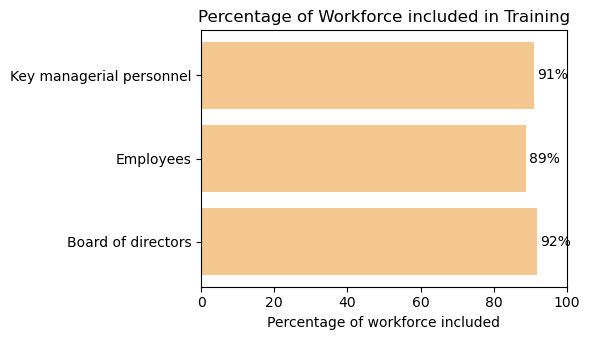

In [32]:
# ──  Cell 1  ────────────────────────────────────────────────────────────────
#   Percentage of Workforce included in Training
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# 1) Load the CSV (read once at the top of the notebook)
# df = pd.read_csv("/mnt/data/combined_brsr_data.csv")
df["Fact Value"] = pd.to_numeric(df["Fact Value"], errors="coerce")

# 2) Pick the latest fiscal year that exists in the file
year_to_plot = df["Fiscal_Year"].max()

# 3) Pull the rows that carry training-coverage data
mask_train = (
    (df["Element Name"] == "PercentageOfPersonsInRespectiveCategoryCoveredByTheAwarenessProgrammes") &
    (df["Fiscal_Year"] == year_to_plot)
)
train_df = df.loc[mask_train, ["Unit", "Fact Value"]].copy()

# 4) Parse the workforce group from Unit, then map to a friendly label
def _to_label(unit_str: str) -> str | None:
    """Return the pretty label or None if this unit is not one of the four groups."""
    u = unit_str or ""
    if "BoardOfDirectors"   in u: return "Board of directors"
    if "KeyManagerial"      in u: return "Key managerial personnel"
    if "Employees"          in u and "EmployeesOther" in u: return "Employees"
    if re.search(r"\bWorkers\b", u): return "Workers"
    return None

train_df["Category"] = train_df["Unit"].apply(_to_label)
train_df.dropna(subset=["Category"], inplace=True)

# 5) Aggregate (mean across companies) and order for display
order = [
    "Board of directors",
    "Employees",
    "Key managerial personnel",
    "Workers",
]
train_plot = (
    train_df.groupby("Category")["Fact Value"].mean().mul(100).reindex(order)
)

# 6) Plot
fig, ax = plt.subplots(figsize=(6, 3.5))
ax.barh(train_plot.index, train_plot.values, color="#F4C790")
for i, v in enumerate(train_plot.values):
    ax.text(v + 1, i, f"{v:.0f}%", va="center")
ax.set_xlim(0, 100)
ax.set_xlabel("Percentage of workforce included")
ax.set_title("Percentage of Workforce included in Training")
plt.tight_layout()
plt.show()


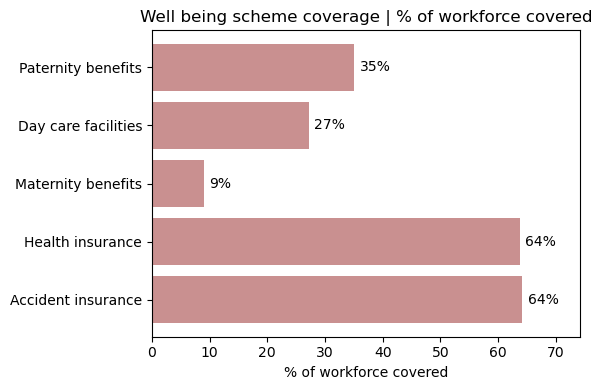

In [33]:
# ──  Cell 2  ────────────────────────────────────────────────────────────────
#   Well-being scheme coverage | % of workforce covered
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# 1) (Re)use df & year_to_plot from Cell 1

# 2) Filter the rows that hold well-being coverage data
mask_wb = (
    (df["Element Name"] == "PercentageOfWellBeingOfEmployeesOrWorkers") &
    (df["Fiscal_Year"] == year_to_plot) &
    df["Unit"].str.startswith("D_Gender_")     # use gender-aggregated rows
)
wb_df = df.loc[mask_wb, ["Unit", "Fact Value"]].copy()

# 3) Extract scheme name from the Unit string and prettify it
def _scheme_label(unit_str: str) -> str | None:
    for raw, pretty in {
        "AccidentInsurance"  : "Accident insurance",
        "HealthInsurance"    : "Health insurance",
        "MaternityBenefits"  : "Maternity benefits",
        "DayCareFacilities"  : "Day care facilities",
        "PaternityBenefits"  : "Paternity benefits",
    }.items():
        if raw in unit_str:
            return pretty
    return None

wb_df["Scheme"] = wb_df["Unit"].apply(_scheme_label)
wb_df.dropna(subset=["Scheme"], inplace=True)

# 4) Aggregate (mean across companies) & order
scheme_order = [
    "Accident insurance",
    "Health insurance",
    "Maternity benefits",
    "Day care facilities",
    "Paternity benefits",
]
wb_plot = (
    wb_df.groupby("Scheme")["Fact Value"].mean().mul(100).reindex(scheme_order)
)
wb_plot.dropna(inplace=True)          # keep only schemes actually present

# 5) Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(wb_plot.index, wb_plot.values, color="#C99090")
for i, v in enumerate(wb_plot.values):
    ax.text(v + 1, i, f"{v:.0f}%", va="center")
ax.set_xlim(0, wb_plot.max() + 10)
ax.set_xlabel("% of workforce covered")
ax.set_title("Well being scheme coverage | % of workforce covered")
plt.tight_layout()
plt.show()


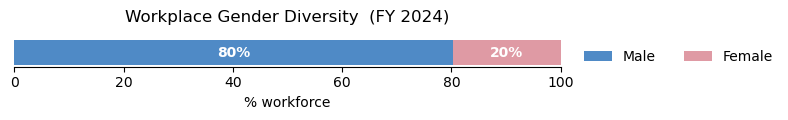

In [34]:
# -----------------------------------------------------------
#  Cell 1: Overall workplace gender diversity (one stacked bar)
# -----------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load once at the top of the notebook

df["Fact Value"] = pd.to_numeric(df["Fact Value"], errors="coerce")

# Latest fiscal year in the data
YEAR = df["Fiscal_Year"].dropna().max()

# 1) ─── employees + workers ─────────────────────────────────
mask_headcount = (
    (df["Fiscal_Year"] == YEAR)
    & (df["Element Name"] == "NumberOfEmployeesOrWorkersIncludingDifferentlyAbled")
)

male_emp = df[mask_headcount & df["Unit"].str.contains(r"_Male_Employees_", regex=True)].loc[:, "Fact Value"].sum()
fem_emp  = df[mask_headcount & df["Unit"].str.contains(r"_Female_Employees_", regex=True)].loc[:, "Fact Value"].sum()

male_wrk = df[mask_headcount & df["Unit"].str.contains(r"_Male_Workers_", regex=True)].loc[:, "Fact Value"].sum()
fem_wrk  = df[mask_headcount & df["Unit"].str.contains(r"_Female_Workers_", regex=True)].loc[:, "Fact Value"].sum()

# 2) ─── board + KMP counts ─────────────────────────────────
mask_year = df["Fiscal_Year"] == YEAR

tot_bod  = df[mask_year & (df["Element Name"] == "TotalNumberOfBoardOfDirectors")]["Fact Value"].sum()
fem_bod  = df[mask_year & (df["Element Name"] == "NumberOfFemaleBoardOfDirectors")]["Fact Value"].sum()

tot_kmp  = df[mask_year & (df["Element Name"] == "TotalNumberOfKeyManagementPersonnel")]["Fact Value"].sum()
fem_kmp  = df[mask_year & (df["Element Name"] == "NumberOfFemaleKeyManagementPersonnel")]["Fact Value"].sum()

# 3) ─── aggregate to 'overall' ─────────────────────────────
male_bod = tot_bod - fem_bod
male_kmp = tot_kmp - fem_kmp

male_total   = male_emp + male_wrk + male_bod + male_kmp
female_total = fem_emp  + fem_wrk  + fem_bod  + fem_kmp
grand_total  = male_total + female_total

female_pct = 100 * female_total / grand_total
male_pct   = 100 - female_pct

# 4) ─── plot the single stacked bar ────────────────────────
fig, ax = plt.subplots(figsize=(8, 1.3))

ax.barh([""], [male_pct],    color="#4F8AC6", label="Male")   # blue
ax.barh([""], [female_pct], color="#DF9AA4", label="Female", left=[male_pct])

ax.set_xlim(0, 100)
ax.set_title("Workplace Gender Diversity  (FY {})".format(int(YEAR)), pad=12)
ax.set_xticks(range(0, 101, 20))
ax.set_xlabel("% workforce")

# add % labels
ax.text(male_pct / 2, 0, f"{male_pct:.0f}%", va="center", ha="center", color="white", weight="bold")
ax.text(male_pct + female_pct / 2, 0, f"{female_pct:.0f}%", va="center", ha="center", color="white", weight="bold")

ax.set_yticks([])
ax.spines[["top", "right", "left"]].set_visible(False)
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1.05), frameon=False)
plt.tight_layout()
plt.show()


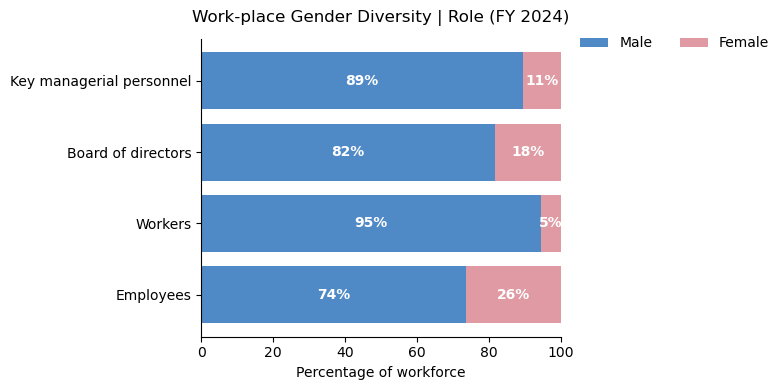

In [35]:
# -----------------------------------------------------------
#  Cell 2: Gender diversity by workforce role (stacked bars)
# -----------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# ── helper to build {male, female} counts for each role
def counts_for_role(role_key):
    """
    role_key ∈ {"Employees", "Workers"}  → pull male/female counts from Unit.
    role_key ∈ {"Board", "KMP"}         → pull from total/female counts.
    returns (male_count, female_count)  (may be (0,0) if not found)
    """
    if role_key == "Employees":
        m = df[mask_headcount & df["Unit"].str.contains(r"_Male_Employees_",   regex=True)]["Fact Value"].sum()
        f = df[mask_headcount & df["Unit"].str.contains(r"_Female_Employees_", regex=True)]["Fact Value"].sum()
    elif role_key == "Workers":
        m = df[mask_headcount & df["Unit"].str.contains(r"_Male_Workers_",   regex=True)]["Fact Value"].sum()
        f = df[mask_headcount & df["Unit"].str.contains(r"_Female_Workers_", regex=True)]["Fact Value"].sum()
    elif role_key == "Board":
        tot = df[mask_year & (df["Element Name"] == "TotalNumberOfBoardOfDirectors")]["Fact Value"].sum()
        f   = df[mask_year & (df["Element Name"] == "NumberOfFemaleBoardOfDirectors")]["Fact Value"].sum()
        m   = tot - f
    elif role_key == "KMP":
        tot = df[mask_year & (df["Element Name"] == "TotalNumberOfKeyManagementPersonnel")]["Fact Value"].sum()
        f   = df[mask_year & (df["Element Name"] == "NumberOfFemaleKeyManagementPersonnel")]["Fact Value"].sum()
        m   = tot - f
    else:
        m = f = 0
    return m, f

# build the data table
roles = ["Employees", "Workers", "Board", "KMP"]
pretty = ["Employees", "Workers", "Board of directors", "Key managerial personnel"]
male_vals, fem_vals = [], []

for rk in roles:
    m, f = counts_for_role(rk)
    tot = m + f
    if tot == 0:
        print(f"⚠️  No data for role '{rk}'. Skipping.")
        continue
    male_vals.append(100 * m / tot)
    fem_vals .append(100 * f / tot)

# final plotting order should match pretty labels
fig, ax = plt.subplots(figsize=(8, 4))

ax.barh(pretty, male_vals, color="#4F8AC6", label="Male")
ax.barh(pretty, fem_vals,  color="#DF9AA4", label="Female", left=male_vals)

# annotate every bar
for y, (m_pct, f_pct) in enumerate(zip(male_vals, fem_vals)):
    ax.text(m_pct / 2,     y, f"{m_pct:.0f}%", va="center", ha="center", color="white", weight="bold")
    ax.text(m_pct + f_pct/2, y, f"{f_pct:.0f}%", va="center", ha="center", color="white", weight="bold")

ax.set_xlim(0, 100)
ax.set_xlabel("Percentage of workforce")
ax.set_title("Work-place Gender Diversity | Role (FY {})".format(int(YEAR)), pad=12)
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1.05), frameon=False)
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()


In [36]:
# # Cell 1 — Median % of CAPEX / R&D spent on env & social impact
# import pandas as pd
# import numpy as np
# import re

# # ───────────────────────────────────────────────────────────────
# # 0  df is assumed to be in memory already
# #     (loaded earlier via pd.read_csv(...))
# # ───────────────────────────────────────────────────────────────

# # 1  Attach Industry  ───────────────────────────────────────────
# if "Industry" not in df.columns:
#     # Look for any column whose name contains "industry" or "sector"
#     ind_candidates = [c for c in df.columns if re.search(r"(industry|sector)", c, re.I)]
#     if ind_candidates:
#         df["Industry"] = df[ind_candidates[0]]
#         print(f"✓ Using column “{ind_candidates[0]}” as Industry")
#     else:
#         raise KeyError(
#             "No Industry/Sector information found in the combined CSV.\n"
#             "Add an Industry column to df (e.g. via a merge) or edit the code "
#             "to supply a dictionary mapping Company_Symbol → Industry."
#         )

# # 2  Attach Cap_Category  ──────────────────────────────────────
# if "Cap_Category" not in df.columns:
#     # 2-a) look for an existing categorical column (e.g. "CapSize", "CapCategory")
#     capcat_candidates = [c for c in df.columns if re.search(r"cap.*category", c, re.I)]
#     if capcat_candidates:
#         df["Cap_Category"] = df[capcat_candidates[0]]
#         print(f"✓ Using column “{capcat_candidates[0]}” as Cap_Category")
#     else:
#         # 2-b) try deriving from a numeric Market-Cap column
#         mcap_candidates = [c for c in df.columns if re.search(r"market.?cap", c, re.I)]
#         if mcap_candidates:
#             mc_col = mcap_candidates[0]
#             df[mc_col] = pd.to_numeric(df[mc_col], errors="coerce")
#             bins   = [-np.inf, 1e4, 5e4, np.inf]   # crore ₹ thresholds
#             labels = ["Small", "Mid", "Large"]
#             df["Cap_Category"] = pd.cut(df[mc_col] / 1e7,  # convert to ₹ crore if raw ₹
#                                         bins=bins, labels=labels)
#             print(f"✓ Derived Cap_Category from numeric column “{mc_col}”")
#         else:
#             raise KeyError(
#                 "Could not find an existing Cap-category column or a numeric Market-Cap "
#                 "column to derive it from. Please add one of these to the CSV."
#             )

# # 3  Identify the two element-names for the metrics ────────────
# def find_element(regex_list):
#     pat = re.compile("|".join(regex_list), re.I)
#     matches = [e for e in df["Element Name"].unique() if pat.search(e)]
#     return matches[0] if matches else None

# capex_elem = find_element(
#     [r"percentage.*capex.*(environment|environ|env).*social", r"percentageofcapex"]
# )
# rand_elem = find_element(
#     [r"percentage.*r.?&.?d.*(environment|environ|env).*social", r"percentageofrandd"]
# )

# if not capex_elem or not rand_elem:
#     raise ValueError(
#         "Could not automatically locate the CAPEX / R&D percentage element names.\n"
#         "Inspect df['Element Name'].unique() and hard-code the two strings if needed."
#     )

# metric_map = {capex_elem: "% of CAPEX", rand_elem: "% of R&D"}

# # 4  Filter to latest FY, DCYMain rows & keep needed columns────
# latest_fy = df["Fiscal_Year"].max()
# mask = (
#     (df["Fiscal_Year"] == latest_fy) &
#     (df["Unit"] == "DCYMain") &
#     df["Element Name"].isin([capex_elem, rand_elem])
# )
# sub = df.loc[mask,
#              ["Company_Symbol", "Industry", "Cap_Category",
#               "Element Name", "Fact Value"]].copy()

# # 5  Drop rows missing metadata, warn once──────────────────────
# bad = sub[sub[["Industry", "Cap_Category"]].isna().any(axis=1)]
# if not bad.empty:
#     print(f"⚠️  {bad['Company_Symbol'].nunique()} ticker(s) lack Industry/Cap_Category → excluded")
# sub.dropna(subset=["Industry", "Cap_Category"], inplace=True)

# # 6  Compute medians────────────────────────────────────────────
# sub["Metric"] = sub["Element Name"].map(metric_map)
# med = (
#     sub.groupby(["Industry", "Cap_Category", "Metric"])["Fact Value"]
#        .median()
#        .mul(100)        # convert 0-1 to %
#        .round(1)
#        .reset_index()
# )

# # 7  Pivot wide: rows = Industry, cols = (Cap×Metric)──────────
# cat_order = ["Large", "Mid", "Small"]
# med["Cap_Category"] = pd.Categorical(med["Cap_Category"], cat_order, ordered=True)

# pivot = (
#     med.pivot_table(index="Industry",
#                     columns=["Cap_Category", "Metric"],
#                     values="Fact Value")
#        .sort_index(axis=1, level=[0, 1])
#        .reindex(sorted(med["Industry"].unique()))
# )

# pivot.head()     # keep “pivot” for Cell 2


In [37]:
# import pandas as pd
# import matplotlib.pyplot as plt


# df['Fact Value'] = pd.to_numeric(df['Fact Value'], errors='coerce')

# # 2) Filter for the five scheme-coverage rows
# prefix_scheme = 'PercentageOfEmployeesOrWorkersCoveredForProvided'
# scheme_df = df[df['Element Name'].str.startswith(prefix_scheme)].copy()

# # 3) Extract suffix and map to human-readable labels
# scheme_df['Suffix'] = scheme_df['Element Name'].str[len(prefix_scheme):]
# label_map_scheme = {
#     'AccidentInsurance'  : 'Accident insurance',
#     'HealthInsurance'    : 'Health insurance',
#     'MaternityBenefits'  : 'Maternity benefits',
#     'DayCareFacilities'  : 'Day care facilities',
#     'PaternityBenefits'  : 'Paternity benefits'
# }
# scheme_df = scheme_df[scheme_df['Suffix'].isin(label_map_scheme)]
# scheme_df['Category'] = scheme_df['Suffix'].map(label_map_scheme)

# # 4) Order rows as desired
# order2 = [
#     'AccidentInsurance',
#     'HealthInsurance',
#     'MaternityBenefits',
#     'DayCareFacilities',
#     'PaternityBenefits'
# ]
# scheme_df['Order'] = scheme_df['Suffix'].apply(order2.index)
# scheme_df.sort_values('Order', inplace=True)

# # 5) Prepare labels & values (scale to %)
# labels = scheme_df['Category'].tolist()
# values = (scheme_df['Fact Value'] * 100).tolist()

# # 6) Plot horizontal bar chart
# fig, ax = plt.subplots(figsize=(6, 4))
# ax.barh(labels, values, color='#C99090')
# for i, v in enumerate(values):
#     ax.text(v + 1, i, f'{v:.0f}%', va='center')
# ax.set_xlim(0, max(values) + 10)
# ax.set_xlabel('% of workforce covered')
# ax.set_title('Well being scheme coverage | % of workforce covered')
# plt.tight_layout()
# plt.show()


In [38]:
# #  Cell — Independent assurance / evaluation (metrics + policies)
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import re

# # df is already in memory
# year = df["Fiscal_Year"].max()          # most-recent FY in the file

# # ------------------------------------------------------------
# # Helper: count YES / NO in a series
# # ------------------------------------------------------------
# def yes_no(series: pd.Series):
#     s = series.astype(str).str.lower().str.strip()
#     yes = s.isin(["yes", "y", "1", "true"]).sum()
#     no  = s.isin(["no",  "n", "0", "false"]).sum()
#     return yes, no

# # ------------------------------------------------------------
# # Part A – Stacked bar for key sustainability metrics
# # ------------------------------------------------------------
# metric_regex = {
#     "Areas of water stress"     : r"AreasOfWaterStress|WaterStress",
#     "Energy Consumption"        : r"EnergyConsumption",
#     "Green-house Gas Emissions" : r"Green.*House.*Gas|GreenHouseGas",
#     "Other than GHG emissions"  : r"Other.*GHG|AirEmissionsOtherThanGHG",
#     "Scope 3 Emissions"         : r"Scope\s*3|Scope3|TotalScope3",
#     "Waste Management"          : r"WasteManagement",
#     "Water discharged"          : r"WaterDischarged",
# }

# rows = []
# for label, pat in metric_regex.items():
#     m = (
#         (df["Fiscal_Year"] == year) &
#         df["Element Name"].str.contains(pat, case=False, regex=True) &
#         df["Element Name"].str.contains("Independent|Assurance|Assessment|Evaluation",
#                                         case=False, regex=True)
#     )
#     yes, no = yes_no(df.loc[m, "Fact Value"]) if m.any() else (0, 0)
#     rows.append((label, yes, no))

# metric_df = (
#     pd.DataFrame(rows, columns=["Metric", "Yes", "No"])
#       .set_index("Metric")
#       .assign(
#           YesPct=lambda d: 100 * d["Yes"] /
#                           (d["Yes"] + d["No"]).replace(0, np.nan),
#           NoPct =lambda d: 100 - d["YesPct"]
#       )
#       .fillna(0)
#       .iloc[::-1]        # reverse order for plotting
# )

# fig, ax = plt.subplots(figsize=(9, 4))
# left = np.zeros(len(metric_df))
# ax.barh(metric_df.index, metric_df["YesPct"], left=left,
#         color="#2E8B57", label="YES")
# left += metric_df["YesPct"]
# ax.barh(metric_df.index, metric_df["NoPct"], left=left,
#         color="#D9534F", label="NO")

# for i, (y, n) in enumerate(zip(metric_df["YesPct"], metric_df["NoPct"])):
#     if y:
#         ax.text(y / 2, i, f"{y:.0f}%", va="center", ha="center",
#                 color="white", fontsize=8)
#     if n:
#         ax.text(y + n / 2, i, f"{n:.0f}%", va="center", ha="center",
#                 color="white", fontsize=8)

# ax.set_xlim(0, 100)
# ax.set_xlabel("% of Companies")
# ax.set_title(f"Independent assurance / evaluation (FY {int(year)})")
# ax.legend(ncol=2, bbox_to_anchor=(1.02, 1.05), frameon=False)
# plt.tight_layout()
# plt.show()

# # ------------------------------------------------------------
# # Part B – Overall policy-working assessment (single pie)
# # ------------------------------------------------------------
# policy_elem = ("HasTheEntityCarriedOutIndependentAssessmentEvaluationOfTheWorkingOf"
#                "ItsPoliciesByAnExternalAgency")
# mask_p = (df["Fiscal_Year"] == year) & (df["Element Name"] == policy_elem)
# yes_p, no_p = yes_no(df.loc[mask_p, "Fact Value"])

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.pie([yes_p, no_p],
#        labels=["YES", "NO"],
#        colors=["#2E8B57", "#D9534F"],
#        autopct="%1.0f%%",
#        startangle=90,
#        wedgeprops=dict(width=0.8))
# ax.set_title("Independent assessment of\npolicy working (overall)")
# ax.axis("equal")
# plt.show()


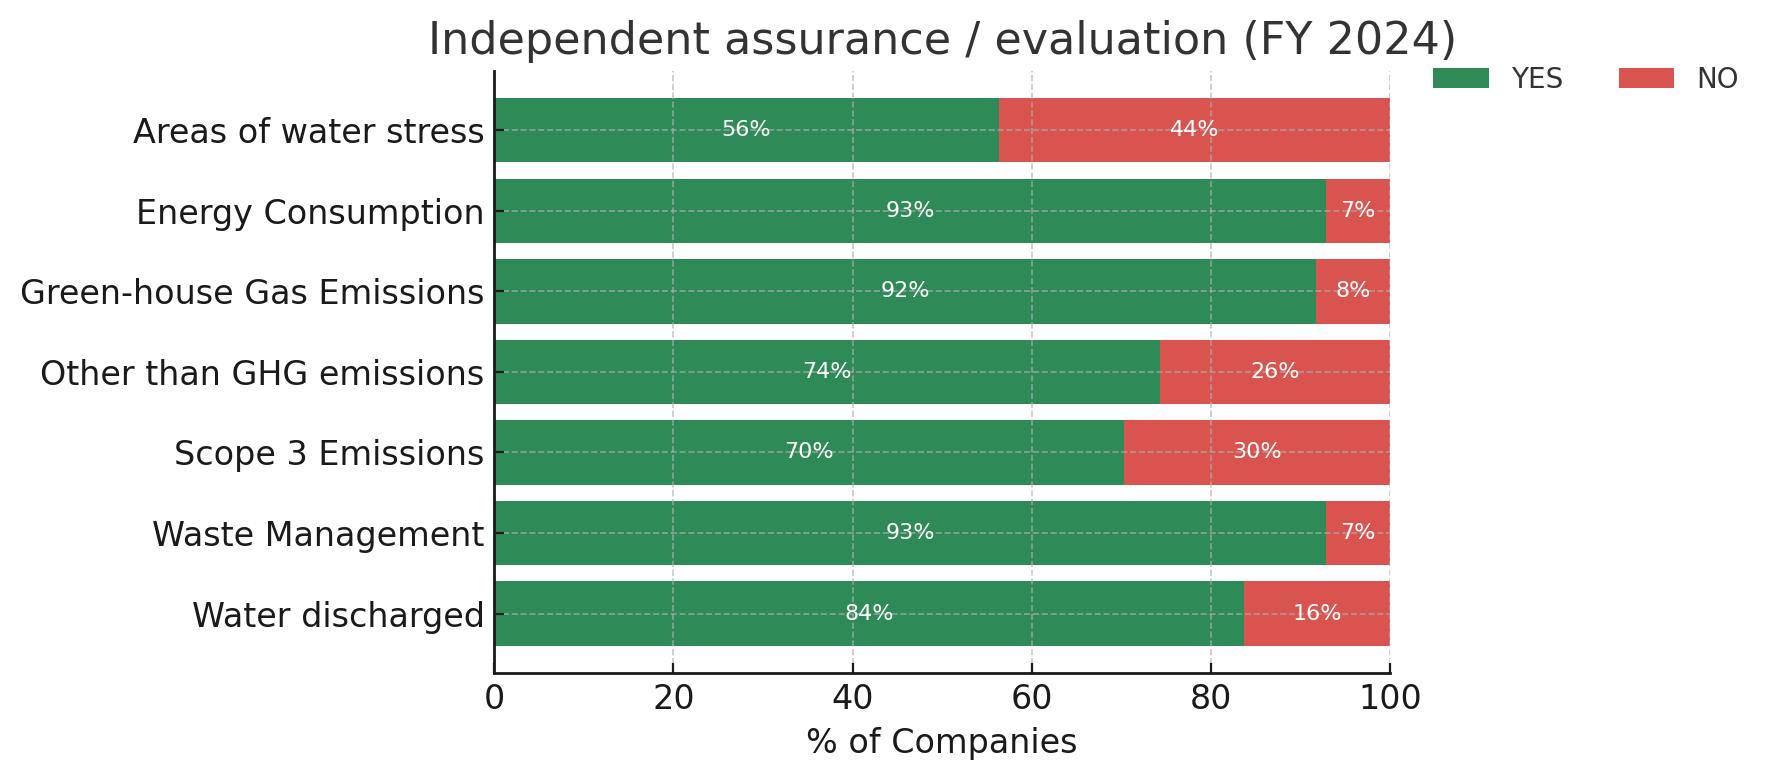

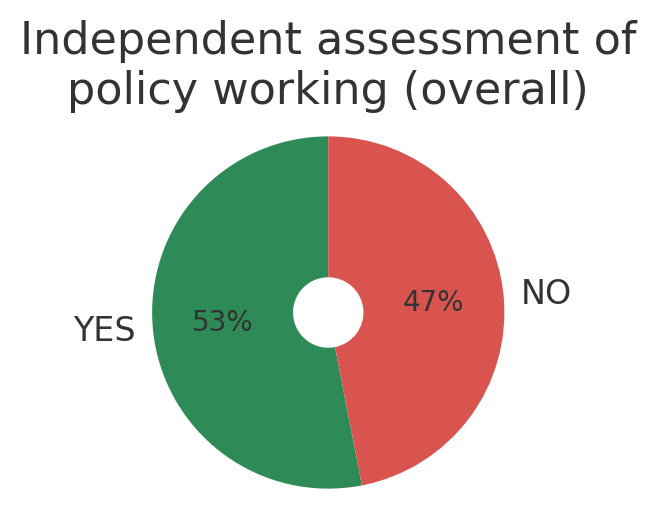